In [1]:
import time
import pickle
import numpy as np
import pprint
import matplotlib.pyplot as plt
from tqdm import tqdm 
import json
from dateutil.parser import parse

In [2]:
from rdbtools import RdbParser, RdbCallback
from rdbtools.encodehelpers import bytes_to_unicode

class PublishCallback(RdbCallback):

    def __init__(self, is_unicode=False, start_ts=float('-inf'), stop_ts=float('+inf')):
        super(PublishCallback, self).__init__(string_escape=None)
        self.ranges = {}
        self.start = start_ts
        self.stop = stop_ts
        self.is_unicode = is_unicode

    def encode_key(self, key):
        return bytes_to_unicode(key, self._escape, skip_printable=True)

    def encode_value(self, val):
        if self.is_unicode:
            return bytes_to_unicode(val, self._escape)
        return val

    def start_sorted_set(self, key, length, expiry, info):
        self.ranges[self.encode_key(key)] = []

    def zadd(self, key, score, member):
        if self.start <= score <= self.stop:
            self.ranges[self.encode_key(key)].append((self.encode_value(member), round(score)))

    def end_sorted_set(self, key):
        encoded_key = self.encode_key(key)
        self.ranges[encoded_key] = list(reversed(self.ranges[encoded_key]))


def parse_dump_file(dump_file, start_ts=float("-inf"), stop_ts=float("+inf")):
    """Parse a redis dump file (rdb) and return the data within.

    Only supports SortedSet.

    Args:
        dump_file (str): Rdb path
        start_ts (float): timestamp of the first value to publish
        stop_ts (float): timestamp of the last value to publish

    Returns:
        ranges (dict): {
                'keyA': [(FrameDataDump1A, Score1A), ..., (FrameDataDumpNA, ScoreNA)],
                'keyB': [(FrameDataDump1B, Score1B), ..., (FrameDataDumpNB, ScoreNB)],
                ...
            }
    """
    t0 = time.time()

    callback = PublishCallback(start_ts=start_ts, stop_ts=stop_ts)
    rdb_parser = RdbParser(callback)
    rdb_parser.parse(dump_file)
    print("Parsed {} in {:.2f} s.".format(dump_file, time.time() - t0))
    print("Contains keys:", callback.ranges.keys())
    for k in callback.ranges.keys():
        print(
            "[{}] start_ts: {} | stop_ts: {}".format(
                k, callback.ranges[k][0][1], callback.ranges[k][-1][1]
            )
        )
    return callback.ranges

In [3]:
from ipywidgets import interact
import ipywidgets as widgets

In [4]:
tracks = parse_dump_file('../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.2.kickoff.rdb')
config = json.load(open('../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.json', 'r'))

Parsed ../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.2.kickoff.rdb in 1.73 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522677422216 | stop_ts: 1522678021096
[left] start_ts: 1522677422334 | stop_ts: 1522678021134


In [46]:

fd, ts = tracks['left'][4000]


fd = pickle.loads(fd)
pprint.pprint(fd.__dict__.keys())
print([fd.player_detections[i].confidence for i in range(len(fd.player_detections))])

dict_keys(['stream_ts', 'last', 'ball_detections', 'phase_state', 'mapping', 'top_view_ball_positions', 'features', 'bboxes', 'valid_frame', 'embeddings', 'ts', 'top_view_player_positions', 'player_detections', 'packed_rects'])
[0, 0, 0, 0, 0, 0]


In [6]:
kickoff_1 = config['phase_events'][2]['ts']
kickoff_time = int(parse(kickoff_1).timestamp()*1000)

In [7]:
config['phase_events'] 

[{'kickoff_team_id': 15,
  'phase': 1,
  'ts': '2018-04-02T13:00:04.376000',
  'type': 'start_phase'},
 {'phase': 1, 'ts': '2018-04-02T13:47:02.983Z', 'type': 'end_phase'},
 {'kickoff_team_id': 4,
  'phase': 2,
  'ts': '2018-04-02T14:02:02.696000',
  'type': 'start_phase'},
 {'phase': 2, 'ts': '2018-04-02T14:50:07.639Z', 'type': 'end_phase'}]

In [8]:
pitch_size=config['pitch_size']
print(pitch_size)

[105, 68]


In [9]:
detections = {'ball':{'left':{}, 'right':{}}, 'players':{'left':{}, 'right':{}}}

timestamps = set()

def ball_ok(ball_pos, ball_det):
    if ball_pos[0] < 0 or ball_pos[1] < 0:
        return False
    if ball_det.confidence < 0.7:
        return False
    return True

for (fd_left, ts_left), (fd_right, ts_right) in tqdm(zip(tracks['left'], tracks['right'])):
    fd_left = pickle.loads(fd_left)
    fd_right = pickle.loads(fd_right)
    if np.abs(ts_left - ts_right) < 100:
        ts_left = ts_right
    timestamps.update({ts_left, ts_right})

    detections['players']['left'][ts_left] = fd_left.top_view_player_positions
    detections['players']['right'][ts_right] = fd_right.top_view_player_positions
    detections['ball']['left'][ts_left] = np.array([bp for bp, bd in zip(fd_left.top_view_ball_positions, fd_left.ball_detections) if ball_ok(bp, bd)])
    detections['ball']['right'][ts_right] = np.array([bp for bp, bd in zip(fd_right.top_view_ball_positions, fd_right.ball_detections) if ball_ok(bp, bd)])
    

14971it [00:05, 2700.56it/s]


In [147]:
print(detections['players']['left'][1527429925546])

KeyError: 1527429925546

1522677722696 1522677722696


<IPython.core.display.Javascript object>


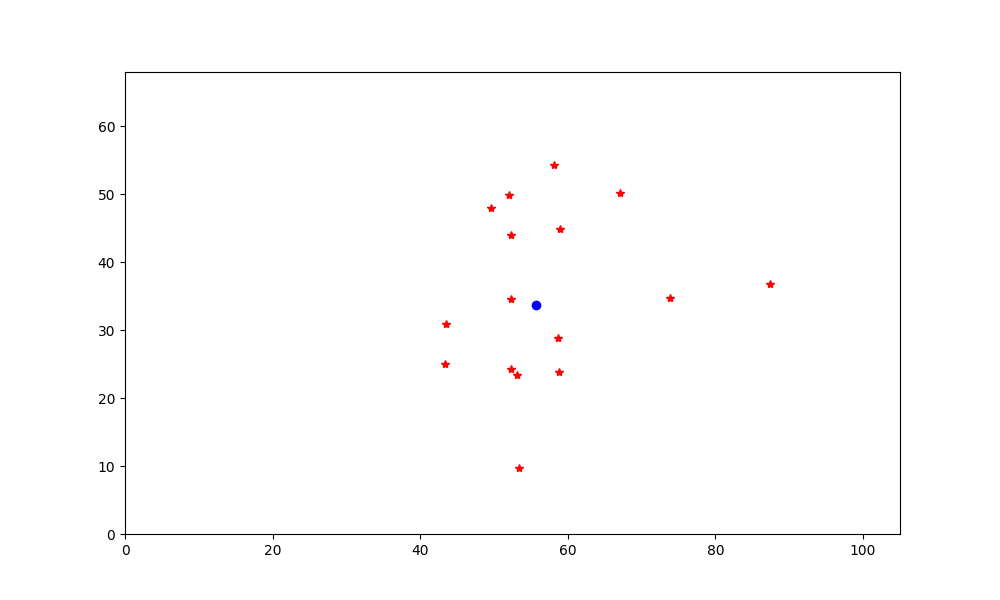

interactive(children=(SelectionSlider(description='ts', index=10035, options=(1522677422216, 1522677422256, 15…

In [10]:
timestamps_list = sorted(list(timestamps))
kickoff_time_ind = np.argmin(np.abs(np.subtract(timestamps_list, kickoff_time)))
kickoff_time_matched = timestamps_list[kickoff_time_ind]
print(kickoff_time, kickoff_time_matched)

%matplotlib notebook

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
left, = plt.plot([], '*r')
right, = plt.plot([], '*r')

left_b, = plt.plot([], 'ob')
right_b, = plt.plot([], 'ob')

plt.xlim([0, 105])
plt.ylim([0, 68])

def update(ts=kickoff_time_matched):
    if ts in detections['players']['left']:
        left.set_ydata(detections['players']['left'][ts][:, 1])
        left.set_xdata(detections['players']['left'][ts][:, 0])
    else:
        left.set_ydata([])
        left.set_xdata([])
        
    if ts in detections['players']['right']:
        right.set_ydata(detections['players']['right'][ts][:, 1])
        right.set_xdata(detections['players']['right'][ts][:, 0])
    else:
        right.set_ydata([])
        right.set_xdata([])

    if ts in detections['ball']['left'] and len(detections['ball']['left'][ts]):
        left_b.set_ydata(detections['ball']['left'][ts][:, 1])
        left_b.set_xdata(detections['ball']['left'][ts][:, 0])
    else:
        left_b.set_ydata([])
        left_b.set_xdata([])        
    if ts in detections['ball']['right'] and len(detections['ball']['right'][ts]):
        right_b.set_ydata(detections['ball']['right'][ts][:, 1])
        right_b.set_xdata(detections['ball']['right'][ts][:, 0])
    else:
        right_b.set_ydata([])
        right_b.set_xdata([])
    
    
wid = widgets.SelectionSlider(
    options=timestamps_list,
    value=kickoff_time_matched,
    continuous_update=True,
    orientation='horizontal',
    readout=True
)
    
interact(update, ts = wid);

In [ ]:
# {'id': 'd1a98e08-0f21-46fe-8457-01ff183ddbeb', 'calibration': {'views': ['left', 'right'], 'reference_landmarks': {'object': 'calibrations/tele2_landmarks.json', 'bucket': 'signality.ironfist.models'}}, 'replay_urls': ['//liveplay.signality.com/data/d1a98e08-0f21-46fe-8457-01ff183ddbeb_phase1.data', '//liveplay.signality.com/data/d1a98e08-0f21-46fe-8457-01ff183ddbeb_phase2.data'], 'camera_mode': 'static', 'away_team': {'colors': {'team': '#000000', 'goalkeeper': '#ffff00'}, 'logo_url': 'http://images.signality.com/team-logos/orebro.png', 'name': 'Örebro SK'}, 'phase_events': [{'type': 'start_phase', 'ts': datetime.datetime(2018, 5, 17, 17, 0, 2, 362000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e4e0>), 'kickoff_team_id': 12, 'phase': 1}, {'type': 'end_phase', 'ts': datetime.datetime(2018, 5, 17, 17, 47, 7, 92000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e518>), 'phase': 1}, {'type': 'start_phase', 'ts': datetime.datetime(2018, 5, 17, 18, 4, 2, 891000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e630>), 'kickoff_team_id': 11, 'phase': 2}, {'type': 'end_phase', 'ts': datetime.datetime(2018, 5, 17, 18, 52, 6, 565000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e6a0>), 'phase': 2}], 'start_time': datetime.datetime(2018, 5, 17, 19, 0, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e780>), 'state': 'Destroyed', 'external_data': {'smc': {'match_id': 3704, 'home_team_id': 11, 'league_id': 12, 'away_team_id': 12}}, 'streams': {'left': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/ca074983-09a2-451f-8730-90efa6701dc8/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 197000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e9e8>)}, 'autofollow_render_segments': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/d890161e-59fa-4f39-9758-b9d5b10357af/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 197000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e9b0>)}, 'virtual_panorama_segments': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/b5e093f3-f8e7-4643-a87a-d9a76256a735/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 197000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61ec88>)}, 'goal_south_segments': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/c841f705-de34-4428-b56e-7c9803ab4eca/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 143000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61eac8>)}, 'right': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/d8112841-7cf8-48ae-89ce-f327c282916c/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 124000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61ea20>)}, 'goal_north_segments': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/9a7b8e83-dbc0-436b-a116-7f8d085057c2/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 141000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61ea58>)}}, 'pitch_size': [105, 68], 'home_team': {'colors': {'team': '#5a9dde', 'goalkeeper': '#ffffff'}, 'logo_url': 'http://images.signality.com/team-logos/djurgarden.png', 'name': 'Djurgårdens IF'}, 'referees': {'colors': '#000000'}, 'competition': 'Allsvenskan', 'redis': {'host': 'redis', 'port': 6379}, 'rethinkdb': {'host': 'db.signality.com', 'user': 'game_viewer', 'db': 'livetrack', 'ssl': {'ca_certs': '/home/ubuntu/workspace/ironfist/ironfist/utils/../applications/livetrack/config/db.signality.cert.pem'}, 'password': 'MmPHrqmXaVeu', 'port': 28015}, 'nchan': {'url': 'http://nchan:8080'}, 'arena': 'Tele2 Arena', 'stats': [{'home_team': {'failed_passes': 163, 'possessing_team': 0, 'passes': 181, 'distance': 62777.64480394193, 'possession': 25067, 'packing': 260}, 'source': 'signality', 'phase': 1, 'away_team': {'failed_passes': 163, 'possessing_team': 1, 'passes': 191, 'distance': 60097.76136929008, 'possession': 23934, 'packing': 252}, 'utc_time': 1526579225125, 'match_time': 2822763}, {'home_team': {'failed_passes': 157, 'possessing_team': 0, 'passes': 147, 'distance': 62576.815733754884, 'possession': 20009, 'packing': 196}, 'source': 'signality', 'phase': 2, 'away_team': {'failed_passes': 158, 'possessing_team': 1, 'passes': 206, 'distance': 57684.92804763888, 'possession': 28384, 'packing': 240}, 'utc_time': 1526583124565, 'match_time': 2881674}], 'video_shape': [2160, 3840, 3], 'rdb': [{'key': '20180517.djurgårdens-if-örebro-sk.2.rdb', 'bucket': 'signality.soccer.backup', 'phase': 2}]}

In [14]:
def select_time(time_list,detections):
    l=list()
    truth_list=list()
    for i in range(len(time_list)):
        truth_list.append(True)
        if time_list[i] in detections['players']['left'] and time_list[i] in detections['players']['right']:
            l.append([time_list[i],time_list[i]])
            truth_list[i]=False
        if i>0:
            if time_list[i-1] in detections['players']['left'] and time_list[i] in detections['players']['right'] and truth_list[i] and truth_list[i-1] and time_list[i]-time_list[i-1]<=20:
                l.append([time_list[i-1],time_list[i]])
                truth_list[i]=False
            if time_list[i] in detections['players']['left'] and time_list[i-1] in detections['players']['right'] and truth_list[i] and truth_list[i-1] and time_list[i]-time_list[i-1]<=20:
                l.append([time_list[i],time_list[i-1]])
                truth_list[i]=False
    return l

l=select_time(timestamps_list,detections)

In [15]:
def players_grid(pitch_size,players):
    compteur=0
    grid=[0 for i in range(32)]
    length=pitch_size[0]
    width=pitch_size[1]
    length_edge=length/8
    width_edge=width/4
    for i in range(len(players)):
        k=0
        j=0
        if players[i][0]<=length and players[i][1]<=width and players[i][0]>=0 and players[i][1]>=0 :
            compteur+=1
            while players[i][0]>(k+1)*length_edge:
                k+=1
            while players[i][1]>(j+1)*width_edge:
                j+=1
            grid[8*j+k]+=1
    if compteur>0:
        new_grid=[float(grid[i])/float(compteur) for i in range(32)]
    else:
        new_grid=grid
    return new_grid

def ball_grid(pitch_size,ball):
    grid=[0 for i in range(35)]
    length=pitch_size[0]
    width=pitch_size[1]
    length_edge=length/7
    width_edge=width/5
    for i in range(len(ball)):
        k=0
        j=0
        if ball[i][0]<=length and ball[i][1]<=width and ball[i][0]>=0 and ball[i][1]>=0:
            while ball[i][0]>(k+1)*length_edge:
                k+=1
            while ball[i][1]>(j+1)*width_edge:
                j+=1
            grid[7*j+k]+=1
    return grid

In [16]:
def pitch_composition_t(time,detections,pitch_size):
    compo=list()
    if isinstance(detections['ball']['left'][time[0]],list):
        compo=compo+ball_grid(pitch_size,detections['ball']['left'][time[0]])
    if isinstance(detections['ball']['left'][time[0]],np.ndarray):
        compo=compo+ball_grid(pitch_size,detections['ball']['left'][time[0]].tolist())
        
    if isinstance(detections['ball']['right'][time[1]],list):
        compo=compo+ball_grid(pitch_size,detections['ball']['right'][time[1]])
    if isinstance(detections['ball']['right'][time[1]],np.ndarray):
        compo=compo+ball_grid(pitch_size,detections['ball']['right'][time[1]].tolist())
    
    if isinstance(detections['players']['left'][time[0]],list):
        compo=compo+players_grid(pitch_size,detections['players']['left'][time[0]])
    if isinstance(detections['players']['left'][time[0]],np.ndarray):
        compo=compo+players_grid(pitch_size,detections['players']['left'][time[0]].tolist())
        
    if isinstance(detections['players']['right'][time[1]],list):
        compo=compo+players_grid(pitch_size,detections['players']['right'][time[1]])
    if isinstance(detections['players']['right'][time[1]],np.ndarray):
        compo=compo+players_grid(pitch_size,detections['players']['right'][time[1]].tolist())
    return compo
    
def pitch_composition(time_list,detections,pitch_size):
    l=select_time(time_list,detections)
    seq=list()
    for i in range(len(l)):
        seq.append(pitch_composition_t(l[i],detections,pitch_size))
    return seq


In [17]:
def movement_sequences(inputs,outputs,regression_output=[]):
    inputs=np.array(inputs)
    new_inputs=list()
    new_outputs=list()
    new_regression_output=list()
    for i in range(len(outputs)-2):
        new_inputs.append(inputs[i+1].tolist()+(inputs[i+2]-inputs[i]).tolist()+(inputs[i+1]-inputs[i]).tolist())
        new_outputs.append(outputs[i+1])
        if len(regression_output)>0:
            new_regression_output.append(regression_output[i+1])
    if len(regression_output)>0:
        return new_inputs,new_outputs,new_regression_output
    return new_inputs,new_outputs

def sequence_composition(time_list,detections,pitch_size,size_sequence,diminish_size):
    sequences=list()
    pitch_compo=pitch_composition(time_list,detections,pitch_size)
    for i in range(0,len(pitch_compo)-size_sequence+1,diminish_size):
        seq_t=list()
        for j in range(0,size_sequence,diminish_size):
            seq_t=seq_t+pitch_compo[i+j]
        sequences.append(seq_t)
    return sequences



In [18]:
def labels_seq_regression(time_list,detections,pitch_size,diminish_size,kickoff_time):
    l=select_time(time_list,detections)
    y=list()
    for i in range(0,len(l)-diminish_size+1):
        if l[i][0]<=kickoff_time and kickoff_time<=l[i+diminish_size-1][0]:
            y.append(1)
        else:
            y.append(0)
    return y

def labels_regression(time_list,detections,pitch_size,size_sequence,diminish_size,kickoff_time):
    label_seq=labels_seq_regression(time_list,detections,pitch_size,diminish_size,kickoff_time)
    sequences=list()
    for i in range(0,len(label_seq)-size_sequence+1,diminish_size):
        seq_t=list()
        for j in range(0,size_sequence,diminish_size):
            seq_t.append(label_seq[i+j])
        sequences.append(seq_t)
    return sequences

def select_kickoff_sequences(time_list,detections,pitch_size,size_sequence,diminish_size,kickoff_time):
    X=sequence_composition(time_list,detections,pitch_size,size_sequence,diminish_size)
    Y=labels(time_list,detections,pitch_size,size_sequence,diminish_size,kickoff_time)
    y=labels_regression(time_list,detections,pitch_size,size_sequence,diminish_size,kickoff_time)
    X,Y,y=movement_sequences(X,Y,y)
    new_X=list()
    new_y=list()
    if Y.count(1)>0:
        print(len(y),len(X))
        print(Y.index(1))
        print(Y.count(1))
        new_y=y[Y.index(1):Y.index(1)+Y.count(1)]
        new_X=X[Y.index(1):Y.index(1)+Y.count(1)]
    return new_X,new_y
    
def detect_kickofftime(outputs):
    new_outputs=list()
    for i in range(len(outputs)):
        new_outputs.append(len(outputs[i])-1-outputs[i].index(1))
    return new_outputs



In [21]:
def labels(time_list,detections,pitch_size,size_sequence,diminish_size,kickoff_time):
    l=select_time(time_list,detections)
    y=list()
    for i in range(0,len(l)-size_sequence+1,diminish_size):
        if max(l[i][0],l[i][1])+1500<=kickoff_time and kickoff_time+2000<=min(l[i+size_sequence-1][0],l[i+size_sequence-1][1]):
            y.append(1)
        else:
            y.append(-1)
    return y

def reduce_size(X,Y,reduc_size):
    compteur=0
    new_X=list()
    new_Y=list()
    for i in range(len(X)):
        if Y[i]==1:
            new_Y.append(1)
            new_X.append(X[i])
            compteur=0
        if Y[i]==-1:
            compteur+=1
        if compteur>=reduc_size:
            compteur=0
            new_Y.append(Y[i])
            new_X.append(X[i])
    return new_X,new_Y
X=sequence_composition(timestamps_list,detections,pitch_size,500,25)
Y=labels(timestamps_list,detections,pitch_size,500,25,kickoff_time_matched)
print(Y.count(1))
#X,Y=movement_sequences(X,Y)
#X,Y=reduce_size(X,Y,10)
Y.index(1)


16


283

In [20]:
import pickle
import glob

In [22]:
import datetime 

wrong_kickofftimes=dict()
wrong_kickofftimes['../kickoff-data-corrected/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.2']=1527429926306
wrong_kickofftimes['../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.1']=1523192430151
wrong_kickofftimes['../kickoff-data-corrected/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.2']=0
wrong_kickofftimes['../kickoff-data-corrected/58bc418b-cf05-415e-9dd1-6f4808535976.2']=0
wrong_kickofftimes['../kickoff-data-corrected/314f4989-398c-45a3-a74f-9f1adac71bf1.2']=0
wrong_kickofftimes['../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.1']=0
wrong_kickofftimes['../kickoff-data-corrected/41c3f1b3-a868-459b-9766-760be49947b2.1']=0
wrong_kickofftimes['../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.1']=0
wrong_kickofftimes['../kickoff-data-corrected/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.1']=0
wrong_kickofftimes['../kickoff-data-corrected/3382a9d0-02ff-4f23-9748-1b715d85b731.1']=0
wrong_kickofftimes['../kickoff-data-corrected/cbcca433-ff77-4927-a5a3-36ff293c12fd.1']=0
wrong_kickofftimes['../kickoff-data-corrected/3382a9d0-02ff-4f23-9748-1b715d85b731.2']=0

#Kickoff dataset 1
wrong_kickofftimes['../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.1']=1522674004376
wrong_kickofftimes['../kickoff-data-corrected/6e26f66b-a921-4919-9d7d-1bd59f935e78.2']=1523642663619
wrong_kickofftimes['../kickoff-data-corrected/27bea627-3caa-47ee-93c3-67f0e26f3034.2']=1523800915381
wrong_kickofftimes['../kickoff-data-corrected/050a1fae-5d48-4048-8f66-a3f12eca843d.1']=1526225401862
wrong_kickofftimes['../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.2']=1524074585473
wrong_kickofftimes['../kickoff-data-corrected/4be6ef54-2541-42d0-a334-e513a535029c.1']=1523714421598
wrong_kickofftimes['../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.1']=1524070829775
wrong_kickofftimes['../kickoff-data-corrected/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.2']=1523205262301
wrong_kickofftimes['../kickoff-data-corrected/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.1']=1524070811969
wrong_kickofftimes['../kickoff-data-corrected/314f4989-398c-45a3-a74f-9f1adac71bf1.1']=1522587657284
wrong_kickofftimes['../kickoff-data-corrected/03d0ac1b-8adb-457d-9519-b6c879a92df3.2']=1526825556446
wrong_kickofftimes['../kickoff-data-corrected/cbcca433-ff77-4927-a5a3-36ff293c12fd.2']=1523297060408
wrong_kickofftimes['../kickoff-data-corrected/a185c6c8-7383-4d19-927f-dc8f70726c34.1']=1523898097097
wrong_kickofftimes['../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.2']=1523383385406
wrong_kickofftimes['../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.1']=1523192632775
wrong_kickofftimes['../kickoff-data-corrected/84e8b33c-d912-495e-9e21-84bdd18e0e04.1']=1523638801059
wrong_kickofftimes['../kickoff-data-corrected/9e627901-09e2-4c84-bf77-6f0ec289fa5f.2']=1522686812893
wrong_kickofftimes['../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.2']=1523196155117
wrong_kickofftimes['../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.2']=1522591530455
wrong_kickofftimes['../kickoff-data-corrected/cd6d495b-8fe4-4586-8861-ba579cf3a6e9.2']=1523801069565
wrong_kickofftimes['../kickoff-data-corrected/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.1']=1527426007786
wrong_kickofftimes['../kickoff-data-corrected/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.2']=1524074540169
wrong_kickofftimes['../kickoff-data-corrected/76d4b783-ae63-4c60-815f-6a81beef6451.1']=1523109744428
wrong_kickofftimes['../kickoff-data-corrected/4be6ef54-2541-42d0-a334-e513a535029c.2']=1523718158518
wrong_kickofftimes['../kickoff-data-corrected/27bea627-3caa-47ee-93c3-67f0e26f3034.1']=1523797259341
wrong_kickofftimes['../kickoff-data-corrected/a185c6c8-7383-4d19-927f-dc8f70726c34.2']=1523901771643
wrong_kickofftimes['../kickoff-data-corrected/9e627901-09e2-4c84-bf77-6f0ec289fa5f.1']=1522683146973
wrong_kickofftimes['../kickoff-data-corrected/84e8b33c-d912-495e-9e21-84bdd18e0e04.2']=1523642441739
wrong_kickofftimes['../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.2']=1523196316815
wrong_kickofftimes['../kickoff-data-corrected/76d4b783-ae63-4c60-815f-6a81beef6451.2']=1523113379828
wrong_kickofftimes['../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.2']=1522677722696
wrong_kickofftimes['../kickoff-data-corrected/bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.1']=1523984448769

def correct_kickoff_time(name_file,right_kickoff_time,phase):
    jsonFile = open(name_file, "r") # Open the JSON file for reading
    config = json.load(jsonFile) # Read the JSON into the buffer
    k=[i for i in range(4) if config['phase_events'][i]['type'] == 'start_phase' and config['phase_events'][i]['phase'] == int(phase)][0]
    jsonFile.close() # Close the JSON file

    ## Working with buffered content
    tmp = config["phase_events"][k]["ts"]
    config["phase_events"][k]["ts"]=datetime.datetime.fromtimestamp(right_kickoff_time/1000).isoformat()
    print("Json file edited")

    ## Save our changes to JSON file
    jsonFile = open(name_file, "w+")
    jsonFile.write(json.dumps(config))
    jsonFile.close()
    
def correct_json_files(name_file_rdb):
    if name_file_rdb in wrong_kickofftimes.keys():
        name_file_json=('..{}.json'.format(name_file_rdb.split('.')[-2]))
        phase=name_file_rdb.split('.')[-1]
        correct_kickoff_time(name_file_json,wrong_kickofftimes[name_file_rdb],phase)

In [36]:
def create_dataset(file_name,reduc_size,problem="classification"):
    compteur=0
    path_to_rdbs = '../kickoff-data-corrected/*.rdb'
    for rdb_file in glob.glob(path_to_rdbs):
        #Edit json file
        game_half = rdb_file.rstrip('.kickoff.rdb')
        phase = game_half.split('.')[-1]
        correct_json_files(game_half)
        
        #Import correct data
        tracks = parse_dump_file('{}.kickoff.rdb'.format(game_half))
        config = json.load(open('..{}.json'.format(game_half.split('.')[-2]), 'r'))
        print('..{}.json'.format(game_half.split('.')[-2]))
        print(config['phase_events'])
        kickoff_1 = [p_e['ts'] for p_e in config['phase_events'] if p_e['type'] == 'start_phase' and p_e['phase'] == int(phase)][0]
        kickoff_time = int(parse(kickoff_1).timestamp()*1000)
        print(kickoff_time)
        pitch_size=config['pitch_size']
        detections = {'ball':{'left':{}, 'right':{}}, 'players':{'left':{}, 'right':{}}}
        timestamps = set()
        for (fd_left, ts_left), (fd_right, ts_right) in tqdm(zip(tracks['left'], tracks['right'])):
            fd_left = pickle.loads(fd_left)
            fd_right = pickle.loads(fd_right)
            if np.abs(ts_left - ts_right) < 100:
                ts_left = ts_right
            timestamps.update({ts_left, ts_right})
            detections['players']['left'][ts_left] = fd_left.top_view_player_positions
            detections['players']['right'][ts_right] = fd_right.top_view_player_positions
            detections['ball']['left'][ts_left] = np.array([bp for bp, bd in zip(fd_left.top_view_ball_positions, fd_left.ball_detections) if ball_ok(bp, bd)])
            detections['ball']['right'][ts_right] = np.array([bp for bp, bd in zip(fd_right.top_view_ball_positions, fd_right.ball_detections) if ball_ok(bp, bd)])
        timestamps_list = sorted(list(timestamps))
        kickoff_time_ind = np.argmin(np.abs(np.subtract(timestamps_list, kickoff_time)))
        kickoff_time_matched = timestamps_list[kickoff_time_ind]
        
        #Create inputs
        
        #Classification
        if problem=="classification":
            X=sequence_composition(timestamps_list,detections,pitch_size,150,5)
            Y=labels(timestamps_list,detections,pitch_size,150,5,kickoff_time_matched)
            print(len(X[0]))
            X,Y=movement_sequences(X,Y)
            print(Y.count(1))
            X,Y=reduce_size(X,Y,reduc_size)
            print(len(X[0]),len(Y))
            print(Y.count(1))
            
            #Create file
            add_data=True
            if Y.count(1)>0 and compteur==0:
                with open(file_name, 'wb') as f:
                    # Pickle the 'data' dictionary using the highest protocol available.
                    pickle.dump([X,Y], f)
                    compteur+=1
                    add_data=False
            if Y.count(1)>0 and add_data:
                with open(file_name, 'ab') as f:
                    # Pickle the 'data' dictionary using the highest protocol available.
                    pickle.dump([X,Y], f)
                    compteur+=1
                    print(compteur)
         
        #Regression
        if problem=="regression":
            X,y=select_kickoff_sequences(timestamps_list,detections,pitch_size,500,25,kickoff_time_matched)
            print(len(X),len(y))
            print(y)
            y=detect_kickofftime(y)
            print(y)
        #Create file
            add_data=True
            if len(y)>0 and compteur==0:
                with open(file_name, 'wb') as f:
                    # Pickle the 'data' dictionary using the highest protocol available.
                    pickle.dump([X,y], f)
                    compteur+=1
                    add_data=False
            if len(y)>0 and add_data:
                with open(file_name, 'ab') as f:
                    # Pickle the 'data' dictionary using the highest protocol available.
                    pickle.dump([X,y], f)
                    compteur+=1
                    print(compteur)
                    

In [37]:
create_dataset('../kickoff-data-corrected/data.pickle.1.10.mov.classif.5',50)

Json file edited


774it [00:00, 3984.10it/s]

Parsed ../kickoff-data-corrected/bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.1.kickoff.rdb in 2.15 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523984148353 | stop_ts: 1523984746873
[right] start_ts: 1523984147529 | stop_ts: 1523984746449
../kickoff-data-corrected/bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.json
[{'phase': 1, 'ts': '2018-04-17T17:00:48.769000', 'kickoff_team_id': 14, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-17T17:45:52.314Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-17T18:00:53.147Z', 'kickoff_team_id': 3, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-17T18:51:00.072Z', 'type': 'end_phase'}]
1523984448769


14964it [00:07, 2086.23it/s]


4020
12
12060 70
12
Json file edited


526it [00:00, 2535.75it/s]

Parsed ../kickoff-data-corrected/41c3f1b3-a868-459b-9766-760be49947b2.1.kickoff.rdb in 2.43 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526316922655 | stop_ts: 1526317521455
[right] start_ts: 1526316922561 | stop_ts: 1526317521441
../kickoff-data-corrected/41c3f1b3-a868-459b-9766-760be49947b2.json
[{'phase': 1, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 9, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-05-14T17:46:22.241Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-05-14T18:01:26.755Z', 'kickoff_team_id': 1, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-05-14T18:49:29.553Z', 'type': 'end_phase'}]
0


14972it [00:08, 1787.18it/s]


4020
0
12060 59
0
Json file edited


476it [00:00, 2374.92it/s]

Parsed ../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.1.kickoff.rdb in 2.00 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522673702216 | stop_ts: 1522674302096
[left] start_ts: 1522673702294 | stop_ts: 1522674302134
../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.json
[{'phase': 1, 'ts': '2018-04-02T13:00:04.376000', 'kickoff_team_id': 15, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-02T13:47:02.983Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-02T14:02:02.696000', 'kickoff_team_id': 4, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-02T14:50:07.639Z', 'type': 'end_phase'}]
1522674004376


14996it [00:07, 1909.29it/s]


4020
13
12060 71
13
2
Json file edited


289it [00:00, 2885.75it/s]

Parsed ../kickoff-data-corrected/6e26f66b-a921-4919-9d7d-1bd59f935e78.2.kickoff.rdb in 1.65 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523642363613 | stop_ts: 1523642962133
[right] start_ts: 1523642362979 | stop_ts: 1523642961819
../kickoff-data-corrected/6e26f66b-a921-4919-9d7d-1bd59f935e78.json
[{'phase': 1, 'ts': '2018-04-13T17:01:26.037Z', 'kickoff_team_id': 3, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-13T17:48:25.115Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-13T18:04:23.619000', 'kickoff_team_id': 8, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-13T18:52:23.632Z', 'type': 'end_phase'}]
1523642663619


14964it [00:06, 2317.98it/s]


4020
12
12060 70
12
3
Json file edited


337it [00:00, 1682.03it/s]

Parsed ../kickoff-data-corrected/27bea627-3caa-47ee-93c3-67f0e26f3034.2.kickoff.rdb in 1.73 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523800614341 | stop_ts: 1523801213661
[right] start_ts: 1523800613851 | stop_ts: 1523801213411
../kickoff-data-corrected/27bea627-3caa-47ee-93c3-67f0e26f3034.json
[{'phase': 1, 'ts': '2018-04-15T13:00:59.341000', 'kickoff_team_id': 4, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-15T13:46:01.064Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-15T14:01:55.381000', 'kickoff_team_id': 9, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-15T14:50:42.654Z', 'type': 'end_phase'}]
1523800915381


14983it [00:07, 2077.22it/s]


4020
13
12060 71
13
4


578it [00:00, 5778.88it/s]

Parsed ../kickoff-data-corrected/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.1.kickoff.rdb in 1.86 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523706912088 | stop_ts: 1523707510928
[left] start_ts: 1523706904558 | stop_ts: 1523707503158
../kickoff-data-corrected/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.json
[{'phase': 1, 'ts': '2018-04-14T12:00:03.074Z', 'kickoff_team_id': 1, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-14T12:45:30.997Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 7, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-14T13:50:58.493Z', 'type': 'end_phase'}]
1523707203074


14966it [00:05, 2712.71it/s]


4020
12
12060 69
12
5
Json file edited


523it [00:00, 2713.84it/s]

Parsed ../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.1.kickoff.rdb in 2.70 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523192129517 | stop_ts: 1523192728157
[right] start_ts: 1523192129071 | stop_ts: 1523192727911
../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.json
[{'phase': 1, 'ts': '2018-04-08T13:00:30.151000', 'kickoff_team_id': 7, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-08T13:47:27.898Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-08T14:02:35.117000', 'kickoff_team_id': 9, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-08T14:51:34.402Z', 'type': 'end_phase'}]
1523192430151


14966it [00:08, 1788.77it/s]


4020
13
12060 71
13
6
Json file edited


257it [00:00, 2565.80it/s]

Parsed ../kickoff-data-corrected/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.2.kickoff.rdb in 1.69 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523710552598 | stop_ts: 1523711150158
[right] start_ts: 1523710560128 | stop_ts: 1523711157928
../kickoff-data-corrected/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.json
[{'phase': 1, 'ts': '2018-04-14T12:00:03.074Z', 'kickoff_team_id': 1, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-14T12:45:30.997Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 7, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-14T13:50:58.493Z', 'type': 'end_phase'}]
0


14941it [00:06, 2469.55it/s]


4020
0
12060 58
0
Json file edited


859it [00:00, 4303.39it/s]

Parsed ../kickoff-data-corrected/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.1.kickoff.rdb in 1.98 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523201094061 | stop_ts: 1523201692981
[left] start_ts: 1523201092829 | stop_ts: 1523201692349
../kickoff-data-corrected/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.json
[{'phase': 1, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 13, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-08T16:17:54.242Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-08T16:34:22.301000', 'kickoff_team_id': 16, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-08T17:23:20.816Z', 'type': 'end_phase'}]
0


14951it [00:07, 1985.27it/s]


4020
0
12060 58
0
Json file edited


471it [00:00, 2451.02it/s]

Parsed ../kickoff-data-corrected/050a1fae-5d48-4048-8f66-a3f12eca843d.1.kickoff.rdb in 2.47 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526225101172 | stop_ts: 1526225700052
[left] start_ts: 1526225101102 | stop_ts: 1526225700022
../kickoff-data-corrected/050a1fae-5d48-4048-8f66-a3f12eca843d.json
[{'phase': 1, 'ts': '2018-05-13T15:30:01.862000', 'kickoff_team_id': 14, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-05-13T16:16:59.553Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-05-13T16:32:02.287Z', 'kickoff_team_id': 8, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-05-13T17:20:33.812Z', 'type': 'end_phase'}]
1526225401862


14972it [00:06, 2139.49it/s]


4020
12
12060 70
12
7
Json file edited


195it [00:00, 1945.58it/s]

Parsed ../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.2.kickoff.rdb in 2.16 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524074286135 | stop_ts: 1524074882975
[right] start_ts: 1524074286793 | stop_ts: 1524074883313
../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.json
[{'phase': 1, 'ts': '2018-04-18T17:00:29.775000', 'kickoff_team_id': 11, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-18T17:46:35.647Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-18T18:03:05.473000', 'kickoff_team_id': 8, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-18T18:52:04.739Z', 'type': 'end_phase'}]
1524074585473


14914it [00:07, 1964.99it/s]


4020
12
12060 70
12
8
Json file edited


667it [00:00, 3415.47it/s]

Parsed ../kickoff-data-corrected/4be6ef54-2541-42d0-a334-e513a535029c.1.kickoff.rdb in 2.04 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523714121038 | stop_ts: 1523714720678
[left] start_ts: 1523714121022 | stop_ts: 1523714720662
../kickoff-data-corrected/4be6ef54-2541-42d0-a334-e513a535029c.json
[{'phase': 1, 'ts': '2018-04-14T14:00:21.598000', 'kickoff_team_id': 16, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-14T14:46:37.899Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-14T15:02:38.518000', 'kickoff_team_id': 5, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-14T15:51:35.702Z', 'type': 'end_phase'}]
1523714421598


14991it [00:07, 1891.29it/s]


4020
12
12060 70
12
9
Json file edited


109it [00:00, 1084.41it/s]

Parsed ../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.1.kickoff.rdb in 4.52 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524070530793 | stop_ts: 1524071128313
[left] start_ts: 1524070530135 | stop_ts: 1524071127975
../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.json
[{'phase': 1, 'ts': '2018-04-18T17:00:29.775000', 'kickoff_team_id': 11, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-18T17:46:35.647Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-18T18:03:05.473000', 'kickoff_team_id': 8, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-18T18:52:04.739Z', 'type': 'end_phase'}]
1524070829775


14939it [00:08, 1680.38it/s]


4020
13
12060 71
13
10
Json file edited


0it [00:00, ?it/s]

Parsed ../kickoff-data-corrected/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.2.kickoff.rdb in 2.19 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523204960829 | stop_ts: 1523205559349
[right] start_ts: 1523204962061 | stop_ts: 1523205559981
../kickoff-data-corrected/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.json
[{'phase': 1, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 13, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-08T16:17:54.242Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-08T16:34:22.301000', 'kickoff_team_id': 16, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-08T17:23:20.816Z', 'type': 'end_phase'}]
1523205262301


14949it [00:07, 1951.51it/s]


4020
12
12060 70
12
11
Json file edited


181it [00:00, 1807.35it/s]

Parsed ../kickoff-data-corrected/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.1.kickoff.rdb in 2.62 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524070510939 | stop_ts: 1524071110739
[right] start_ts: 1524070510889 | stop_ts: 1524071110729
../kickoff-data-corrected/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.json
[{'phase': 1, 'ts': '2018-04-18T17:00:11.969000', 'kickoff_team_id': 13, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-18T17:47:10.874Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-18T18:02:20.169000', 'kickoff_team_id': 9, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-18T18:49:19.022Z', 'type': 'end_phase'}]
1524070811969


14996it [00:09, 1584.54it/s]


4020
13
12060 71
13
12
Json file edited


134it [00:00, 1333.34it/s]

Parsed ../kickoff-data-corrected/314f4989-398c-45a3-a74f-9f1adac71bf1.1.kickoff.rdb in 2.16 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522587361602 | stop_ts: 1522587961442
[left] start_ts: 1522587361524 | stop_ts: 1522587961404
../kickoff-data-corrected/314f4989-398c-45a3-a74f-9f1adac71bf1.json
[{'phase': 1, 'ts': '2018-04-01T13:00:57.284000', 'kickoff_team_id': 9, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-01T13:47:08.486Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 5, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-01T14:50:51.103Z', 'type': 'end_phase'}]
1522587657284


14908it [00:07, 1934.57it/s]


4020
12
12060 70
12
13
Json file edited


641it [00:00, 2990.91it/s]

Parsed ../kickoff-data-corrected/03d0ac1b-8adb-457d-9519-b6c879a92df3.2.kickoff.rdb in 2.00 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526825255814 | stop_ts: 1526825853694
[left] start_ts: 1526825255686 | stop_ts: 1526825853606
../kickoff-data-corrected/03d0ac1b-8adb-457d-9519-b6c879a92df3.json
[{'phase': 1, 'ts': '2018-05-20T13:10:06.054Z', 'kickoff_team_id': 10, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-05-20T13:55:08.940Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-05-20T14:12:36.446000', 'kickoff_team_id': 2, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-05-20T15:02:18.183Z', 'type': 'end_phase'}]
1526825556446


14948it [00:07, 2078.02it/s]


4020
12
12060 70
12
14
Json file edited


292it [00:00, 2912.76it/s]

Parsed ../kickoff-data-corrected/cbcca433-ff77-4927-a5a3-36ff293c12fd.2.kickoff.rdb in 1.53 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523296748330 | stop_ts: 1523297346370
[left] start_ts: 1523296760048 | stop_ts: 1523297356248
../kickoff-data-corrected/cbcca433-ff77-4927-a5a3-36ff293c12fd.json
[{'phase': 1, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 15, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-09T17:47:46.113Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-09T18:04:20.408000', 'kickoff_team_id': 5, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-09T18:53:12.188Z', 'type': 'end_phase'}]
1523297060408


14906it [00:05, 2605.02it/s]


4020
13
12060 69
13
15
Json file edited


266it [00:00, 1339.07it/s]

Parsed ../kickoff-data-corrected/a185c6c8-7383-4d19-927f-dc8f70726c34.1.kickoff.rdb in 3.43 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523897795697 | stop_ts: 1523898395297
[left] start_ts: 1523897795243 | stop_ts: 1523898395043
../kickoff-data-corrected/a185c6c8-7383-4d19-927f-dc8f70726c34.json
[{'phase': 1, 'ts': '2018-04-16T17:01:37.097000', 'kickoff_team_id': 15, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-16T17:46:39.313Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-16T18:02:51.643000', 'kickoff_team_id': 2, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-16T18:49:49.424Z', 'type': 'end_phase'}]
1523898097097


14991it [00:10, 1400.80it/s]


4020
12
12060 70
12
16
Json file edited


177it [00:00, 1766.45it/s]

Parsed ../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.2.kickoff.rdb in 2.25 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523383083286 | stop_ts: 1523383682846
[left] start_ts: 1523383083898 | stop_ts: 1523383683138
../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.json
[{'phase': 1, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 6, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-10T17:47:16.674Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-10T18:03:05.406000', 'kickoff_team_id': 2, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-10T18:51:05.058Z', 'type': 'end_phase'}]
1523383385406


14982it [00:07, 2084.37it/s]


4020
13
12060 71
13
17
Json file edited


145it [00:00, 1448.98it/s]

Parsed ../kickoff-data-corrected/3382a9d0-02ff-4f23-9748-1b715d85b731.1.kickoff.rdb in 4.24 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523805900650 | stop_ts: 1523806499170
[left] start_ts: 1523805900082 | stop_ts: 1523806498882
../kickoff-data-corrected/3382a9d0-02ff-4f23-9748-1b715d85b731.json
[{'phase': 1, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 6, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-15T16:16:00.459Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 13, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-15T17:19:35.565Z', 'type': 'end_phase'}]
0


14963it [00:10, 1484.10it/s]


4020
0
12060 59
0
Json file edited


203it [00:00, 2028.62it/s]

Parsed ../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.1.kickoff.rdb in 2.98 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522587371411 | stop_ts: 1522587968931
[left] start_ts: 1522587371575 | stop_ts: 1522587969015
../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.json
[{'phase': 1, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 1, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-01T13:47:53.692Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-01T14:05:30.455000', 'kickoff_team_id': 2, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-01T14:53:51.954Z', 'type': 'end_phase'}]
0


14937it [00:08, 1705.00it/s]


4020
0
12060 58
0
Json file edited


123it [00:00, 1222.26it/s]

Parsed ../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.1.kickoff.rdb in 2.64 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523192332775 | stop_ts: 1523192929695
[left] start_ts: 1523192332019 | stop_ts: 1523192929339
../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.json
[{'phase': 1, 'ts': '2018-04-08T13:03:52.775000', 'kickoff_team_id': 11, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-08T13:48:52.077Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-08T14:05:16.815000', 'kickoff_team_id': 14, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-08T14:53:40.200Z', 'type': 'end_phase'}]
1523192632775


14925it [00:08, 1671.93it/s]


4020
13
12060 71
13
18
Json file edited


367it [00:00, 3665.62it/s]

Parsed ../kickoff-data-corrected/3382a9d0-02ff-4f23-9748-1b715d85b731.2.kickoff.rdb in 1.97 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523809596650 | stop_ts: 1523810194170
[left] start_ts: 1523809596082 | stop_ts: 1523810193882
../kickoff-data-corrected/3382a9d0-02ff-4f23-9748-1b715d85b731.json
[{'phase': 1, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 6, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-15T16:16:00.459Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 13, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-15T17:19:35.565Z', 'type': 'end_phase'}]
0


14938it [00:06, 2377.64it/s]


4020
0
12060 59
0
Json file edited


356it [00:00, 3547.16it/s]

Parsed ../kickoff-data-corrected/84e8b33c-d912-495e-9e21-84bdd18e0e04.1.kickoff.rdb in 2.22 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523638502169 | stop_ts: 1523639099769
[left] start_ts: 1523638501659 | stop_ts: 1523639099539
../kickoff-data-corrected/84e8b33c-d912-495e-9e21-84bdd18e0e04.json
[{'phase': 1, 'ts': '2018-04-13T17:00:01.059000', 'kickoff_team_id': 12, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-13T17:45:38.365Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-13T18:00:41.739000', 'kickoff_team_id': 14, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-13T18:47:41.972Z', 'type': 'end_phase'}]
1523638801059


14940it [00:07, 2067.07it/s]


4020
12
12060 70
12
19
Json file edited


439it [00:00, 2174.38it/s]

Parsed ../kickoff-data-corrected/9e627901-09e2-4c84-bf77-6f0ec289fa5f.2.kickoff.rdb in 1.81 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522686513973 | stop_ts: 1522687111853
[left] start_ts: 1522686514029 | stop_ts: 1522687111869
../kickoff-data-corrected/9e627901-09e2-4c84-bf77-6f0ec289fa5f.json
[{'phase': 1, 'ts': '2018-04-02T15:32:26.973000', 'kickoff_team_id': 7, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-02T16:17:34.362Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-02T16:33:32.893000', 'kickoff_team_id': 8, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-02T17:22:39.373Z', 'type': 'end_phase'}]
1522686812893


14946it [00:06, 2196.91it/s]


4020
12
12060 70
12
20
Json file edited


658it [00:00, 3200.72it/s]

Parsed ../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.2.kickoff.rdb in 2.12 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523195853031 | stop_ts: 1523196452911
[left] start_ts: 1523195853517 | stop_ts: 1523196453157
../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.json
[{'phase': 1, 'ts': '2018-04-08T13:00:30.151000', 'kickoff_team_id': 7, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-08T13:47:27.898Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-08T14:02:35.117000', 'kickoff_team_id': 9, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-08T14:51:34.402Z', 'type': 'end_phase'}]
1523196155117


14992it [00:08, 1704.88it/s]


4020
12
12060 70
12
21
Json file edited


231it [00:00, 2307.01it/s]

Parsed ../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.2.kickoff.rdb in 2.05 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522591235411 | stop_ts: 1522591831931
[left] start_ts: 1522591235535 | stop_ts: 1522591832015
../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.json
[{'phase': 1, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 1, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-01T13:47:53.692Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-01T14:05:30.455000', 'kickoff_team_id': 2, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-01T14:53:51.954Z', 'type': 'end_phase'}]
1522591530455


14913it [00:07, 2089.86it/s]


4020
12
12060 70
12
22
Json file edited


461it [00:00, 2342.83it/s]

Parsed ../kickoff-data-corrected/cd6d495b-8fe4-4586-8861-ba579cf3a6e9.2.kickoff.rdb in 2.08 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523800767685 | stop_ts: 1523801367045
[right] start_ts: 1523800767317 | stop_ts: 1523801366837
../kickoff-data-corrected/cd6d495b-8fe4-4586-8861-ba579cf3a6e9.json
[{'phase': 1, 'ts': '2018-04-15T13:01:26.995Z', 'kickoff_team_id': None, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-15T13:48:30.166Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-15T14:04:29.565000', 'kickoff_team_id': None, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-15T14:54:33.364Z', 'type': 'end_phase'}]
1523801069565


14984it [00:07, 2131.60it/s]


4020
12
12060 70
12
23
Json file edited


0it [00:00, ?it/s]

Parsed ../kickoff-data-corrected/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.1.kickoff.rdb in 2.90 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527425706666 | stop_ts: 1527426305466
[right] start_ts: 1527425706526 | stop_ts: 1527426305406
../kickoff-data-corrected/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.json
[{'phase': 1, 'ts': '2018-05-27T13:00:07.786000', 'kickoff_team_id': 2, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-05-27T13:48:06.407Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-05-27T14:05:26.306000', 'kickoff_team_id': 9, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-05-27T14:54:05.123Z', 'type': 'end_phase'}]
1527426007786


14971it [00:10, 1398.84it/s]


4020
13
12060 71
13
24
Json file edited


259it [00:00, 2581.97it/s]

Parsed ../kickoff-data-corrected/314f4989-398c-45a3-a74f-9f1adac71bf1.2.kickoff.rdb in 1.65 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522591069602 | stop_ts: 1522591667442
[left] start_ts: 1522591069484 | stop_ts: 1522591667404
../kickoff-data-corrected/314f4989-398c-45a3-a74f-9f1adac71bf1.json
[{'phase': 1, 'ts': '2018-04-01T13:00:57.284000', 'kickoff_team_id': 9, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-01T13:47:08.486Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 5, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-01T14:50:51.103Z', 'type': 'end_phase'}]
0


14947it [00:06, 2312.05it/s]


4020
0
12060 59
0
Json file edited


348it [00:00, 1754.16it/s]

Parsed ../kickoff-data-corrected/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.2.kickoff.rdb in 2.35 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524074238899 | stop_ts: 1524074838739
[right] start_ts: 1524074238929 | stop_ts: 1524074838729
../kickoff-data-corrected/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.json
[{'phase': 1, 'ts': '2018-04-18T17:00:11.969000', 'kickoff_team_id': 13, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-18T17:47:10.874Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-18T18:02:20.169000', 'kickoff_team_id': 9, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-18T18:49:19.022Z', 'type': 'end_phase'}]
1524074540169


14996it [00:09, 1614.42it/s]


4020
13
12060 71
13
25
Json file edited


96it [00:00, 954.46it/s]

Parsed ../kickoff-data-corrected/76d4b783-ae63-4c60-815f-6a81beef6451.1.kickoff.rdb in 4.19 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523109442596 | stop_ts: 1523110041116
[right] start_ts: 1523109442628 | stop_ts: 1523110041148
../kickoff-data-corrected/76d4b783-ae63-4c60-815f-6a81beef6451.json
[{'phase': 1, 'ts': '2018-04-07T14:02:24.428000', 'kickoff_team_id': 12, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-07T14:47:22.773Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-07T15:02:59.828000', 'kickoff_team_id': 4, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-07T15:50:52.908Z', 'type': 'end_phase'}]
1523109744428


14963it [00:08, 1663.42it/s]


4020
12
12060 70
12
26
Json file edited


460it [00:00, 2206.59it/s]

Parsed ../kickoff-data-corrected/4be6ef54-2541-42d0-a334-e513a535029c.2.kickoff.rdb in 1.75 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523717857062 | stop_ts: 1523718456662
[right] start_ts: 1523717857078 | stop_ts: 1523718456678
../kickoff-data-corrected/4be6ef54-2541-42d0-a334-e513a535029c.json
[{'phase': 1, 'ts': '2018-04-14T14:00:21.598000', 'kickoff_team_id': 16, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-14T14:46:37.899Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-14T15:02:38.518000', 'kickoff_team_id': 5, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-14T15:51:35.702Z', 'type': 'end_phase'}]
1523718158518


14991it [00:06, 2292.45it/s]


4020
13
12060 71
13
27
Json file edited


209it [00:00, 2083.48it/s]

Parsed ../kickoff-data-corrected/27bea627-3caa-47ee-93c3-67f0e26f3034.1.kickoff.rdb in 4.42 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523796958381 | stop_ts: 1523797557661
[right] start_ts: 1523796957851 | stop_ts: 1523797557411
../kickoff-data-corrected/27bea627-3caa-47ee-93c3-67f0e26f3034.json
[{'phase': 1, 'ts': '2018-04-15T13:00:59.341000', 'kickoff_team_id': 4, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-15T13:46:01.064Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-15T14:01:55.381000', 'kickoff_team_id': 9, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-15T14:50:42.654Z', 'type': 'end_phase'}]
1523797259341


14984it [00:07, 1893.09it/s]


4020
12
12060 70
12
28
Json file edited


164it [00:00, 1629.90it/s]

Parsed ../kickoff-data-corrected/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.2.kickoff.rdb in 2.73 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527429626666 | stop_ts: 1527430225466
[right] start_ts: 1527429626566 | stop_ts: 1527430225406
../kickoff-data-corrected/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.json
[{'phase': 1, 'ts': '2018-05-27T13:00:07.786000', 'kickoff_team_id': 2, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-05-27T13:48:06.407Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-05-27T14:05:26.306000', 'kickoff_team_id': 9, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-05-27T14:54:05.123Z', 'type': 'end_phase'}]
1527429926306


14971it [00:08, 1790.22it/s]


4020
12
12060 70
12
29
Json file edited


0it [00:00, ?it/s]

Parsed ../kickoff-data-corrected/a185c6c8-7383-4d19-927f-dc8f70726c34.2.kickoff.rdb in 1.60 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523901471243 | stop_ts: 1523902070043
[right] start_ts: 1523901471657 | stop_ts: 1523902070297
../kickoff-data-corrected/a185c6c8-7383-4d19-927f-dc8f70726c34.json
[{'phase': 1, 'ts': '2018-04-16T17:01:37.097000', 'kickoff_team_id': 15, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-16T17:46:39.313Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-16T18:02:51.643000', 'kickoff_team_id': 2, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-16T18:49:49.424Z', 'type': 'end_phase'}]
1523901771643


14967it [00:05, 2557.19it/s]


4020
13
12060 71
13
30
Json file edited


582it [00:00, 2826.05it/s]

Parsed ../kickoff-data-corrected/9e627901-09e2-4c84-bf77-6f0ec289fa5f.1.kickoff.rdb in 1.94 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522682846069 | stop_ts: 1522683445869
[right] start_ts: 1522682845973 | stop_ts: 1522683445853
../kickoff-data-corrected/9e627901-09e2-4c84-bf77-6f0ec289fa5f.json
[{'phase': 1, 'ts': '2018-04-02T15:32:26.973000', 'kickoff_team_id': 7, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-02T16:17:34.362Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-02T16:33:32.893000', 'kickoff_team_id': 8, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-02T17:22:39.373Z', 'type': 'end_phase'}]
1522683146973


14997it [00:05, 2606.07it/s]


4020
13
12060 71
13
31
Json file edited


951it [00:00, 4613.93it/s]

Parsed ../kickoff-data-corrected/84e8b33c-d912-495e-9e21-84bdd18e0e04.2.kickoff.rdb in 1.58 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523642141699 | stop_ts: 1523642740539
[right] start_ts: 1523642142209 | stop_ts: 1523642740769
../kickoff-data-corrected/84e8b33c-d912-495e-9e21-84bdd18e0e04.json
[{'phase': 1, 'ts': '2018-04-13T17:00:01.059000', 'kickoff_team_id': 12, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-13T17:45:38.365Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-13T18:00:41.739000', 'kickoff_team_id': 14, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-13T18:47:41.972Z', 'type': 'end_phase'}]
1523642441739


14965it [00:05, 2891.95it/s]


4020
12
12060 70
12
32
Json file edited


104it [00:00, 1034.79it/s]

Parsed ../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.1.kickoff.rdb in 1.65 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523379375326 | stop_ts: 1523379973846
[left] start_ts: 1523379375938 | stop_ts: 1523379974138
../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.json
[{'phase': 1, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 6, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-10T17:47:16.674Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-10T18:03:05.406000', 'kickoff_team_id': 2, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-10T18:51:05.058Z', 'type': 'end_phase'}]
0


14955it [00:06, 2343.75it/s]


4020
0
12060 59
0
Json file edited


261it [00:00, 2605.47it/s]

Parsed ../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.2.kickoff.rdb in 2.04 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523196016735 | stop_ts: 1523196614695
[left] start_ts: 1523196016019 | stop_ts: 1523196614339
../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.json
[{'phase': 1, 'ts': '2018-04-08T13:03:52.775000', 'kickoff_team_id': 11, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-08T13:48:52.077Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-08T14:05:16.815000', 'kickoff_team_id': 14, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-08T14:53:40.200Z', 'type': 'end_phase'}]
1523196316815


14949it [00:07, 2074.28it/s]


4020
13
12060 71
13
33
Json file edited


218it [00:00, 2179.99it/s]

Parsed ../kickoff-data-corrected/76d4b783-ae63-4c60-815f-6a81beef6451.2.kickoff.rdb in 1.62 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523113078596 | stop_ts: 1523113675116
[right] start_ts: 1523113078628 | stop_ts: 1523113675148
../kickoff-data-corrected/76d4b783-ae63-4c60-815f-6a81beef6451.json
[{'phase': 1, 'ts': '2018-04-07T14:02:24.428000', 'kickoff_team_id': 12, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-07T14:47:22.773Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-07T15:02:59.828000', 'kickoff_team_id': 4, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-07T15:50:52.908Z', 'type': 'end_phase'}]
1523113379828


14913it [00:07, 2049.56it/s]


4020
13
12060 71
13
34
Json file edited


430it [00:00, 4299.20it/s]

Parsed ../kickoff-data-corrected/cbcca433-ff77-4927-a5a3-36ff293c12fd.1.kickoff.rdb in 1.86 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523292948088 | stop_ts: 1523293544248
[right] start_ts: 1523292936370 | stop_ts: 1523293534370
../kickoff-data-corrected/cbcca433-ff77-4927-a5a3-36ff293c12fd.json
[{'phase': 1, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 15, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-09T17:47:46.113Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-09T18:04:20.408000', 'kickoff_team_id': 5, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-09T18:53:12.188Z', 'type': 'end_phase'}]
0


14861it [00:05, 2533.80it/s]


4020
0
12060 57
0
Json file edited


0it [00:00, ?it/s]

Parsed ../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.2.kickoff.rdb in 2.11 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522677422216 | stop_ts: 1522678021096
[left] start_ts: 1522677422334 | stop_ts: 1522678021134
../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.json
[{'phase': 1, 'ts': '2018-04-02T13:00:04.376000', 'kickoff_team_id': 15, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-02T13:47:02.983Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-02T14:02:02.696000', 'kickoff_team_id': 4, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-02T14:50:07.639Z', 'type': 'end_phase'}]
1522677722696


14971it [00:05, 2634.21it/s]


4020
12
12060 70
12
35
Json file edited


439it [00:00, 4387.31it/s]

Parsed ../kickoff-data-corrected/58bc418b-cf05-415e-9dd1-6f4808535976.2.kickoff.rdb in 1.46 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523297009328 | stop_ts: 1523297605968
[left] start_ts: 1523297008806 | stop_ts: 1523297605726
../kickoff-data-corrected/58bc418b-cf05-415e-9dd1-6f4808535976.json
[{'phase': 1, 'ts': '2018-04-09T17:00:56.973Z', 'kickoff_team_id': 8, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-09T17:47:19.651Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 10, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-09T18:57:31.075Z', 'type': 'end_phase'}]
0


14917it [00:06, 2426.15it/s]


4020
0
12060 58
0


In [23]:
create_dataset('../kickoff-data-corrected/data.pickle.1.10.mov.regression',10,"regression")

815it [00:00, 4224.87it/s]

Parsed ../kickoff-data-corrected/bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.1.kickoff.rdb in 2.16 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523984148353 | stop_ts: 1523984746873
[right] start_ts: 1523984147529 | stop_ts: 1523984746449
../kickoff-data-corrected/bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.json
[{'kickoff_team_id': 14, 'ts': '2018-04-17T17:00:46.604Z', 'type': 'start_phase', 'phase': 1}, {'ts': '2018-04-17T17:45:52.314Z', 'type': 'end_phase', 'phase': 1}, {'kickoff_team_id': 3, 'ts': '2018-04-17T18:00:53.147Z', 'type': 'start_phase', 'phase': 2}, {'ts': '2018-04-17T18:51:00.072Z', 'type': 'end_phase', 'phase': 2}]
1523984446604


14964it [00:07, 2024.73it/s]


576 576
280
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

557it [00:00, 2739.47it/s]

Parsed ../kickoff-data-corrected/41c3f1b3-a868-459b-9766-760be49947b2.1.kickoff.rdb in 2.47 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1526316922655 | stop_ts: 1526317521455
[right] start_ts: 1526316922561 | stop_ts: 1526317521441
../kickoff-data-corrected/41c3f1b3-a868-459b-9766-760be49947b2.json
[{'kickoff_team_id': 9, 'type': 'start_phase', 'phase': 1, 'ts': '1970-01-01T00:00:00'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-14T17:46:22.241Z'}, {'kickoff_team_id': 1, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-14T18:01:26.755Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-14T18:49:29.553Z'}]
0


14972it [00:07, 2016.20it/s]


0 0
[]
[]
Json file edited


240it [00:00, 2398.65it/s]

Parsed ../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.1.kickoff.rdb in 2.66 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522673702216 | stop_ts: 1522674302096
[left] start_ts: 1522673702294 | stop_ts: 1522674302134
../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.json
[{'kickoff_team_id': 15, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-02T13:00:04.376000'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-02T13:47:02.983Z'}, {'kickoff_team_id': 4, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-02T14:02:01.386Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-02T14:50:07.639Z'}]
1522674004376


14996it [00:07, 1955.98it/s]


577 577
283
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

384it [00:00, 3832.13it/s]

Parsed ../kickoff-data-corrected/6e26f66b-a921-4919-9d7d-1bd59f935e78.2.kickoff.rdb in 1.34 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523642363613 | stop_ts: 1523642962133
[right] start_ts: 1523642362979 | stop_ts: 1523642961819
../kickoff-data-corrected/6e26f66b-a921-4919-9d7d-1bd59f935e78.json
[{'kickoff_team_id': 3, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-13T17:01:26.037Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-13T17:48:25.115Z'}, {'kickoff_team_id': 8, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-13T18:04:23.619000'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-13T18:52:23.632Z'}]
1523642663619


14964it [00:06, 2444.65it/s]


576 576
281
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

181it [00:00, 1800.51it/s]

Parsed ../kickoff-data-corrected/27bea627-3caa-47ee-93c3-67f0e26f3034.2.kickoff.rdb in 1.54 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523800614341 | stop_ts: 1523801213661
[right] start_ts: 1523800613851 | stop_ts: 1523801213411
../kickoff-data-corrected/27bea627-3caa-47ee-93c3-67f0e26f3034.json
[{'kickoff_team_id': 4, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-15T13:00:57.169Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-15T13:46:01.064Z'}, {'kickoff_team_id': 9, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-15T14:01:55.381000'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-15T14:50:42.654Z'}]
1523800915381


14983it [00:06, 2225.29it/s]


577 577
282
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

881it [00:00, 4585.11it/s]

Parsed ../kickoff-data-corrected/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.1.kickoff.rdb in 1.85 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523706912088 | stop_ts: 1523707510928
[left] start_ts: 1523706904558 | stop_ts: 1523707503158
../kickoff-data-corrected/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.json
[{'kickoff_team_id': 1, 'type': 'start_phase', 'ts': '2018-04-14T12:00:03.074Z', 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-14T12:45:30.997Z', 'phase': 1}, {'kickoff_team_id': 7, 'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-14T13:50:58.493Z', 'phase': 2}]
1523707203074


14966it [00:05, 2749.52it/s]


569 569
272
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

527it [00:00, 2736.74it/s]

Parsed ../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.1.kickoff.rdb in 1.73 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523192129517 | stop_ts: 1523192728157
[right] start_ts: 1523192129071 | stop_ts: 1523192727911
../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.json
[{'kickoff_team_id': 7, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-08T13:00:30.151000'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-08T13:47:27.898Z'}, {'kickoff_team_id': 9, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-08T14:02:34.797000'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-08T14:51:34.402Z'}]
1523192430151


14966it [00:08, 1862.03it/s]


576 576
282
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

637it [00:00, 3192.84it/s]

Parsed ../kickoff-data-corrected/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.2.kickoff.rdb in 1.74 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523710552598 | stop_ts: 1523711150158
[right] start_ts: 1523710560128 | stop_ts: 1523711157928
../kickoff-data-corrected/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.json
[{'kickoff_team_id': 1, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-14T12:00:03.074Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-14T12:45:30.997Z'}, {'kickoff_team_id': 7, 'type': 'start_phase', 'phase': 2, 'ts': '1970-01-01T00:00:00'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-14T13:50:58.493Z'}]
0


14941it [00:05, 2593.82it/s]


0 0
[]
[]
Json file edited


865it [00:00, 4385.71it/s]

Parsed ../kickoff-data-corrected/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.1.kickoff.rdb in 1.98 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523201094061 | stop_ts: 1523201692981
[left] start_ts: 1523201092829 | stop_ts: 1523201692349
../kickoff-data-corrected/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.json
[{'kickoff_team_id': 13, 'type': 'start_phase', 'phase': 1, 'ts': '1970-01-01T00:00:00'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-08T16:17:54.242Z'}, {'kickoff_team_id': 16, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-08T16:34:19.995Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-08T17:23:20.816Z'}]
0


14951it [00:07, 2006.71it/s]


0 0
[]
[]
Json file edited


413it [00:00, 2080.51it/s]

Parsed ../kickoff-data-corrected/050a1fae-5d48-4048-8f66-a3f12eca843d.1.kickoff.rdb in 2.56 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526225101172 | stop_ts: 1526225700052
[left] start_ts: 1526225101102 | stop_ts: 1526225700022
../kickoff-data-corrected/050a1fae-5d48-4048-8f66-a3f12eca843d.json
[{'kickoff_team_id': 14, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-13T15:30:01.862000'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-13T16:16:59.553Z'}, {'kickoff_team_id': 8, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-13T16:32:02.287Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-13T17:20:33.812Z'}]
1526225401862


14972it [00:07, 2070.55it/s]


577 577
282
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

215it [00:00, 2146.61it/s]

Parsed ../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.2.kickoff.rdb in 1.59 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524074286135 | stop_ts: 1524074882975
[right] start_ts: 1524074286793 | stop_ts: 1524074883313
../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.json
[{'kickoff_team_id': 11, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-18T17:00:28.694Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-18T17:46:35.647Z'}, {'kickoff_team_id': 8, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-18T18:03:05.473000'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-18T18:52:04.739Z'}]
1524074585473


14914it [00:07, 2114.93it/s]


574 574
280
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

709it [00:00, 3596.97it/s]

Parsed ../kickoff-data-corrected/4be6ef54-2541-42d0-a334-e513a535029c.1.kickoff.rdb in 2.01 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523714121038 | stop_ts: 1523714720678
[left] start_ts: 1523714121022 | stop_ts: 1523714720662
../kickoff-data-corrected/4be6ef54-2541-42d0-a334-e513a535029c.json
[{'kickoff_team_id': 16, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-14T14:00:21.598000'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-14T14:46:37.899Z'}, {'kickoff_team_id': 5, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-14T15:02:36.879Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-14T15:51:35.702Z'}]
1523714421598


14991it [00:07, 2019.03it/s]


578 578
282
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

113it [00:00, 1125.16it/s]

Parsed ../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.1.kickoff.rdb in 2.89 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524070530793 | stop_ts: 1524071128313
[left] start_ts: 1524070530135 | stop_ts: 1524071127975
../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.json
[{'kickoff_team_id': 11, 'type': 'start_phase', 'ts': '2018-04-18T17:00:29.775000', 'phase': 1}, {'type': 'end_phase', 'ts': '2018-04-18T17:46:35.647Z', 'phase': 1}, {'kickoff_team_id': 8, 'type': 'start_phase', 'ts': '2018-04-18T18:03:05.473000', 'phase': 2}, {'type': 'end_phase', 'ts': '2018-04-18T18:52:04.739Z', 'phase': 2}]
1524070829775


14939it [00:08, 1677.36it/s]


575 575
280
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

246it [00:00, 2452.03it/s]

Parsed ../kickoff-data-corrected/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.2.kickoff.rdb in 1.62 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523204960829 | stop_ts: 1523205559349
[right] start_ts: 1523204962061 | stop_ts: 1523205559981
../kickoff-data-corrected/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.json
[{'kickoff_team_id': 13, 'type': 'start_phase', 'phase': 1, 'ts': '1970-01-01T00:00:00'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-08T16:17:54.242Z'}, {'kickoff_team_id': 16, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-08T16:34:22.301000'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-08T17:23:20.816Z'}]
1523205262301


14949it [00:07, 1903.31it/s]


575 575
282
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

156it [00:00, 806.12it/s]

Parsed ../kickoff-data-corrected/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.1.kickoff.rdb in 2.62 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524070510939 | stop_ts: 1524071110739
[right] start_ts: 1524070510889 | stop_ts: 1524071110729
../kickoff-data-corrected/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.json
[{'kickoff_team_id': 13, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-18T17:00:11.969000'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-18T17:47:10.874Z'}, {'kickoff_team_id': 9, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-18T18:02:18.645Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-18T18:49:19.022Z'}]
1524070811969


14996it [00:09, 1592.60it/s]


578 578
282
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

254it [00:00, 1298.77it/s]

Parsed ../kickoff-data-corrected/314f4989-398c-45a3-a74f-9f1adac71bf1.1.kickoff.rdb in 2.12 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522587361602 | stop_ts: 1522587961442
[left] start_ts: 1522587361524 | stop_ts: 1522587961404
../kickoff-data-corrected/314f4989-398c-45a3-a74f-9f1adac71bf1.json
[{'kickoff_team_id': 9, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-01T13:00:57.284000'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-01T13:47:08.486Z'}, {'kickoff_team_id': 5, 'type': 'start_phase', 'phase': 2, 'ts': '1970-01-01T00:00:00'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-01T14:50:51.103Z'}]
1522587657284


14908it [00:07, 2009.93it/s]


571 571
277
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

465it [00:00, 4648.70it/s]

Parsed ../kickoff-data-corrected/03d0ac1b-8adb-457d-9519-b6c879a92df3.2.kickoff.rdb in 1.43 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526825255814 | stop_ts: 1526825853694
[left] start_ts: 1526825255686 | stop_ts: 1526825853606
../kickoff-data-corrected/03d0ac1b-8adb-457d-9519-b6c879a92df3.json
[{'kickoff_team_id': 10, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-20T13:10:06.054Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-20T13:55:08.940Z'}, {'kickoff_team_id': 2, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-20T14:12:36.446000'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-20T15:02:18.183Z'}]
1526825556446


14948it [00:06, 2253.21it/s]


575 575
282
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

422it [00:00, 4205.36it/s]

Parsed ../kickoff-data-corrected/cbcca433-ff77-4927-a5a3-36ff293c12fd.2.kickoff.rdb in 1.22 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523296748330 | stop_ts: 1523297346370
[left] start_ts: 1523296760048 | stop_ts: 1523297356248
../kickoff-data-corrected/cbcca433-ff77-4927-a5a3-36ff293c12fd.json
[{'kickoff_team_id': 15, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-09T17:00:44.667Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-09T17:47:46.113Z'}, {'kickoff_team_id': 5, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-09T18:04:20.408000'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-09T18:53:12.188Z'}]
1523297060408


14906it [00:05, 2808.93it/s]


563 563
282
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

278it [00:00, 1414.64it/s]

Parsed ../kickoff-data-corrected/a185c6c8-7383-4d19-927f-dc8f70726c34.1.kickoff.rdb in 3.42 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523897795697 | stop_ts: 1523898395297
[left] start_ts: 1523897795243 | stop_ts: 1523898395043
../kickoff-data-corrected/a185c6c8-7383-4d19-927f-dc8f70726c34.json
[{'kickoff_team_id': 15, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-16T17:01:37.097000'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-16T17:46:39.313Z'}, {'kickoff_team_id': 2, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-16T18:02:50.296Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-16T18:49:49.424Z'}]
1523898097097


14991it [00:10, 1436.75it/s]


577 577
283
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

436it [00:00, 2116.90it/s]

Parsed ../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.2.kickoff.rdb in 1.61 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523383083286 | stop_ts: 1523383682846
[left] start_ts: 1523383083898 | stop_ts: 1523383683138
../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.json
[{'kickoff_team_id': 6, 'type': 'start_phase', 'phase': 1, 'ts': '1970-01-01T00:00:00'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-10T17:47:16.674Z'}, {'kickoff_team_id': 2, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-10T18:03:05.406000'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-10T18:51:05.058Z'}]
1523383385406


14982it [00:07, 2134.61it/s]


577 577
283
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

275it [00:00, 1345.29it/s]

Parsed ../kickoff-data-corrected/3382a9d0-02ff-4f23-9748-1b715d85b731.1.kickoff.rdb in 4.15 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523805900650 | stop_ts: 1523806499170
[left] start_ts: 1523805900082 | stop_ts: 1523806498882
../kickoff-data-corrected/3382a9d0-02ff-4f23-9748-1b715d85b731.json
[{'kickoff_team_id': 6, 'type': 'start_phase', 'phase': 1, 'ts': '1970-01-01T00:00:00'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-15T16:16:00.459Z'}, {'kickoff_team_id': 13, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-15T16:31:33.353Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-15T17:19:35.565Z'}]
0


14963it [00:09, 1532.19it/s]


0 0
[]
[]
Json file edited


374it [00:00, 1917.99it/s]

Parsed ../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.1.kickoff.rdb in 1.94 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522587371411 | stop_ts: 1522587968931
[left] start_ts: 1522587371575 | stop_ts: 1522587969015
../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.json
[{'kickoff_team_id': 1, 'type': 'start_phase', 'phase': 1, 'ts': '1970-01-01T00:00:00'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-01T13:47:53.692Z'}, {'kickoff_team_id': 2, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-01T14:05:32.177Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-01T14:53:51.954Z'}]
0


14937it [00:08, 1733.57it/s]


0 0
[]
[]
Json file edited


130it [00:00, 1296.18it/s]

Parsed ../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.1.kickoff.rdb in 2.64 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523192332775 | stop_ts: 1523192929695
[left] start_ts: 1523192332019 | stop_ts: 1523192929339
../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.json
[{'kickoff_team_id': 11, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-08T13:03:52.775000'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-08T13:48:52.077Z'}, {'kickoff_team_id': 14, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-08T14:05:14.493Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-08T14:53:40.200Z'}]
1523192632775


14925it [00:08, 1742.21it/s]


574 574
281
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

347it [00:00, 3464.88it/s]

Parsed ../kickoff-data-corrected/3382a9d0-02ff-4f23-9748-1b715d85b731.2.kickoff.rdb in 1.49 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523809596650 | stop_ts: 1523810194170
[left] start_ts: 1523809596082 | stop_ts: 1523810193882
../kickoff-data-corrected/3382a9d0-02ff-4f23-9748-1b715d85b731.json
[{'kickoff_team_id': 6, 'type': 'start_phase', 'phase': 1, 'ts': '1970-01-01T00:00:00'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-15T16:16:00.459Z'}, {'kickoff_team_id': 13, 'type': 'start_phase', 'phase': 2, 'ts': '1970-01-01T00:00:00'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-15T17:19:35.565Z'}]
0


14938it [00:06, 2425.49it/s]


0 0
[]
[]
Json file edited


380it [00:00, 3798.10it/s]

Parsed ../kickoff-data-corrected/84e8b33c-d912-495e-9e21-84bdd18e0e04.1.kickoff.rdb in 2.21 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523638502169 | stop_ts: 1523639099769
[left] start_ts: 1523638501659 | stop_ts: 1523639099539
../kickoff-data-corrected/84e8b33c-d912-495e-9e21-84bdd18e0e04.json
[{'kickoff_team_id': 12, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-13T17:00:01.059000'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-13T17:45:38.365Z'}, {'kickoff_team_id': 14, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-13T18:00:40.466Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-13T18:47:41.972Z'}]
1523638801059


14940it [00:06, 2144.34it/s]


575 575
280
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

253it [00:00, 2526.27it/s]

Parsed ../kickoff-data-corrected/9e627901-09e2-4c84-bf77-6f0ec289fa5f.2.kickoff.rdb in 1.74 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522686513973 | stop_ts: 1522687111853
[left] start_ts: 1522686514029 | stop_ts: 1522687111869
../kickoff-data-corrected/9e627901-09e2-4c84-bf77-6f0ec289fa5f.json
[{'kickoff_team_id': 7, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-02T15:32:25.029Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-02T16:17:34.362Z'}, {'kickoff_team_id': 8, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-02T16:33:32.893000'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-02T17:22:39.373Z'}]
1522686812893


14946it [00:06, 2439.69it/s]


576 576
280
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

345it [00:00, 3443.21it/s]

Parsed ../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.2.kickoff.rdb in 1.63 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523195853031 | stop_ts: 1523196452911
[left] start_ts: 1523195853517 | stop_ts: 1523196453157
../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.json
[{'kickoff_team_id': 7, 'type': 'start_phase', 'ts': '2018-04-08T13:00:30.151000', 'phase': 1}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-08T13:47:27.898Z'}, {'kickoff_team_id': 9, 'type': 'start_phase', 'ts': '2018-04-08T14:02:35.117000', 'phase': 2}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-08T14:51:34.402Z'}]
1523196155117


14992it [00:08, 1782.45it/s]


577 577
283
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

585it [00:00, 2913.67it/s]

Parsed ../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.2.kickoff.rdb in 1.34 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522591235411 | stop_ts: 1522591831931
[left] start_ts: 1522591235535 | stop_ts: 1522591832015
../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.json
[{'kickoff_team_id': 1, 'type': 'start_phase', 'phase': 1, 'ts': '1970-01-01T00:00:00'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-01T13:47:53.692Z'}, {'kickoff_team_id': 2, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-01T14:05:30.455000'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-01T14:53:51.954Z'}]
1522591530455


14913it [00:06, 2364.90it/s]


574 574
276
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

522it [00:00, 2600.72it/s]

Parsed ../kickoff-data-corrected/cd6d495b-8fe4-4586-8861-ba579cf3a6e9.2.kickoff.rdb in 1.48 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523800767685 | stop_ts: 1523801367045
[right] start_ts: 1523800767317 | stop_ts: 1523801366837
../kickoff-data-corrected/cd6d495b-8fe4-4586-8861-ba579cf3a6e9.json
[{'kickoff_team_id': None, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-15T13:01:26.995Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-15T13:48:30.166Z'}, {'kickoff_team_id': None, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-15T14:04:29.565000'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-15T14:54:33.364Z'}]
1523801069565


14984it [00:06, 2281.26it/s]


577 577
283
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

304it [00:00, 1499.03it/s]

Parsed ../kickoff-data-corrected/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.1.kickoff.rdb in 2.90 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527425706666 | stop_ts: 1527426305466
[right] start_ts: 1527425706526 | stop_ts: 1527426305406
../kickoff-data-corrected/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.json
[{'kickoff_team_id': 2, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-27T13:00:07.786000'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-27T13:48:06.407Z'}, {'kickoff_team_id': 9, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-27T14:05:26.306000'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-27T14:54:05.123Z'}]
1527426007786


14971it [00:10, 1380.75it/s]


576 576
282
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

511it [00:00, 2518.32it/s]

Parsed ../kickoff-data-corrected/314f4989-398c-45a3-a74f-9f1adac71bf1.2.kickoff.rdb in 1.62 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522591069602 | stop_ts: 1522591667442
[left] start_ts: 1522591069484 | stop_ts: 1522591667404
../kickoff-data-corrected/314f4989-398c-45a3-a74f-9f1adac71bf1.json
[{'kickoff_team_id': 9, 'type': 'start_phase', 'ts': '2018-04-01T13:00:57.284000', 'phase': 1}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-01T13:47:08.486Z'}, {'kickoff_team_id': 5, 'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'phase': 2}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-01T14:50:51.103Z'}]
0


14947it [00:06, 2376.17it/s]


0 0
[]
[]
Json file edited


181it [00:00, 1804.03it/s]

Parsed ../kickoff-data-corrected/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.2.kickoff.rdb in 2.34 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1524074238899 | stop_ts: 1524074838739
[right] start_ts: 1524074238929 | stop_ts: 1524074838729
../kickoff-data-corrected/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.json
[{'kickoff_team_id': 13, 'type': 'start_phase', 'ts': '2018-04-18T17:00:11.969000', 'phase': 1}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-18T17:47:10.874Z'}, {'kickoff_team_id': 9, 'type': 'start_phase', 'ts': '2018-04-18T18:02:20.169000', 'phase': 2}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-18T18:49:19.022Z'}]
1524074540169


14996it [00:08, 1720.46it/s]


578 578
283
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

202it [00:00, 1005.65it/s]

Parsed ../kickoff-data-corrected/76d4b783-ae63-4c60-815f-6a81beef6451.1.kickoff.rdb in 2.79 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523109442596 | stop_ts: 1523110041116
[right] start_ts: 1523109442628 | stop_ts: 1523110041148
../kickoff-data-corrected/76d4b783-ae63-4c60-815f-6a81beef6451.json
[{'kickoff_team_id': 12, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-07T14:02:24.428000'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-07T14:47:22.773Z'}, {'kickoff_team_id': 4, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-07T15:02:55.779Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-07T15:50:52.908Z'}]
1523109744428


14963it [00:08, 2153.11it/s]


577 577
283
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

222it [00:00, 2219.50it/s]

Parsed ../kickoff-data-corrected/4be6ef54-2541-42d0-a334-e513a535029c.2.kickoff.rdb in 1.88 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523717857062 | stop_ts: 1523718456662
[right] start_ts: 1523717857078 | stop_ts: 1523718456678
../kickoff-data-corrected/4be6ef54-2541-42d0-a334-e513a535029c.json
[{'kickoff_team_id': 16, 'type': 'start_phase', 'ts': '2018-04-14T14:00:21.598000', 'phase': 1}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-14T14:46:37.899Z'}, {'kickoff_team_id': 5, 'type': 'start_phase', 'ts': '2018-04-14T15:02:38.518000', 'phase': 2}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-14T15:51:35.702Z'}]
1523718158518


14991it [00:06, 2333.24it/s]


578 578
283
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

245it [00:00, 2447.45it/s]

Parsed ../kickoff-data-corrected/27bea627-3caa-47ee-93c3-67f0e26f3034.1.kickoff.rdb in 2.79 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523796958381 | stop_ts: 1523797557661
[right] start_ts: 1523796957851 | stop_ts: 1523797557411
../kickoff-data-corrected/27bea627-3caa-47ee-93c3-67f0e26f3034.json
[{'kickoff_team_id': 4, 'type': 'start_phase', 'ts': '2018-04-15T13:00:59.341000', 'phase': 1}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-15T13:46:01.064Z'}, {'kickoff_team_id': 9, 'type': 'start_phase', 'ts': '2018-04-15T14:01:55.381000', 'phase': 2}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-15T14:50:42.654Z'}]
1523797259341


14984it [00:07, 1893.93it/s]


577 577
282
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

327it [00:00, 1568.55it/s]

Parsed ../kickoff-data-corrected/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.2.kickoff.rdb in 2.24 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1527429626666 | stop_ts: 1527430225466
[right] start_ts: 1527429626566 | stop_ts: 1527430225406
../kickoff-data-corrected/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.json
[{'kickoff_team_id': 2, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-27T13:00:07.786000'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-27T13:48:06.407Z'}, {'kickoff_team_id': 9, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-27T14:05:26.306000'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-27T14:54:05.123Z'}]
1527429926306


14971it [00:08, 1713.18it/s]


577 577
281
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

345it [00:00, 3445.33it/s]

Parsed ../kickoff-data-corrected/a185c6c8-7383-4d19-927f-dc8f70726c34.2.kickoff.rdb in 1.57 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523901471243 | stop_ts: 1523902070043
[right] start_ts: 1523901471657 | stop_ts: 1523902070297
../kickoff-data-corrected/a185c6c8-7383-4d19-927f-dc8f70726c34.json
[{'kickoff_team_id': 15, 'type': 'start_phase', 'ts': '2018-04-16T17:01:37.097000', 'phase': 1}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-16T17:46:39.313Z'}, {'kickoff_team_id': 2, 'type': 'start_phase', 'ts': '2018-04-16T18:02:51.643000', 'phase': 2}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-16T18:49:49.424Z'}]
1523901771643


14967it [00:05, 2581.05it/s]


576 576
281
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

600it [00:00, 2909.99it/s]

Parsed ../kickoff-data-corrected/9e627901-09e2-4c84-bf77-6f0ec289fa5f.1.kickoff.rdb in 1.94 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1522682846069 | stop_ts: 1522683445869
[right] start_ts: 1522682845973 | stop_ts: 1522683445853
../kickoff-data-corrected/9e627901-09e2-4c84-bf77-6f0ec289fa5f.json
[{'kickoff_team_id': 7, 'type': 'start_phase', 'ts': '2018-04-02T15:32:26.973000', 'phase': 1}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-02T16:17:34.362Z'}, {'kickoff_team_id': 8, 'type': 'start_phase', 'ts': '2018-04-02T16:33:32.893000', 'phase': 2}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-02T17:22:39.373Z'}]
1522683146973


14997it [00:05, 2633.79it/s]


578 578
282
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

991it [00:00, 4859.88it/s]

Parsed ../kickoff-data-corrected/84e8b33c-d912-495e-9e21-84bdd18e0e04.2.kickoff.rdb in 1.53 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523642141699 | stop_ts: 1523642740539
[right] start_ts: 1523642142209 | stop_ts: 1523642740769
../kickoff-data-corrected/84e8b33c-d912-495e-9e21-84bdd18e0e04.json
[{'kickoff_team_id': 12, 'type': 'start_phase', 'ts': '2018-04-13T17:00:01.059000', 'phase': 1}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-13T17:45:38.365Z'}, {'kickoff_team_id': 14, 'type': 'start_phase', 'ts': '2018-04-13T18:00:41.739000', 'phase': 2}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-13T18:47:41.972Z'}]
1523642441739


14965it [00:05, 2904.47it/s]


576 576
281
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

106it [00:00, 1059.23it/s]

Parsed ../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.1.kickoff.rdb in 1.62 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523379375326 | stop_ts: 1523379973846
[left] start_ts: 1523379375938 | stop_ts: 1523379974138
../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.json
[{'kickoff_team_id': 6, 'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'phase': 1}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-10T17:47:16.674Z'}, {'kickoff_team_id': 2, 'type': 'start_phase', 'ts': '2018-04-10T18:03:05.406000', 'phase': 2}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-10T18:51:05.058Z'}]
0


14955it [00:06, 2296.46it/s]


0 0
[]
[]
Json file edited


585it [00:00, 2939.78it/s]

Parsed ../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.2.kickoff.rdb in 2.04 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523196016735 | stop_ts: 1523196614695
[left] start_ts: 1523196016019 | stop_ts: 1523196614339
../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.json
[{'kickoff_team_id': 11, 'type': 'start_phase', 'ts': '2018-04-08T13:03:52.775000', 'phase': 1}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-08T13:48:52.077Z'}, {'kickoff_team_id': 14, 'type': 'start_phase', 'ts': '2018-04-08T14:05:16.815000', 'phase': 2}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-08T14:53:40.200Z'}]
1523196316815


14949it [00:07, 2075.51it/s]


575 575
281
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

228it [00:00, 2273.43it/s]

Parsed ../kickoff-data-corrected/76d4b783-ae63-4c60-815f-6a81beef6451.2.kickoff.rdb in 1.96 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523113078596 | stop_ts: 1523113675116
[right] start_ts: 1523113078628 | stop_ts: 1523113675148
../kickoff-data-corrected/76d4b783-ae63-4c60-815f-6a81beef6451.json
[{'kickoff_team_id': 12, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-07T14:02:24.428000'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-07T14:47:22.773Z'}, {'kickoff_team_id': 4, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-07T15:02:59.828000'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-07T15:50:52.908Z'}]
1523113379828


14913it [00:06, 2140.54it/s]


575 575
283
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

931it [00:00, 4692.24it/s]

Parsed ../kickoff-data-corrected/cbcca433-ff77-4927-a5a3-36ff293c12fd.1.kickoff.rdb in 1.57 s.
Contains keys: dict_keys(['left', 'right'])
[left] start_ts: 1523292948088 | stop_ts: 1523293544248
[right] start_ts: 1523292936370 | stop_ts: 1523293534370
../kickoff-data-corrected/cbcca433-ff77-4927-a5a3-36ff293c12fd.json
[{'kickoff_team_id': 15, 'type': 'start_phase', 'ts': '1970-01-01T00:00:00', 'phase': 1}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-09T17:47:46.113Z'}, {'kickoff_team_id': 5, 'type': 'start_phase', 'ts': '2018-04-09T18:04:20.408000', 'phase': 2}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-09T18:53:12.188Z'}]
0


14861it [00:05, 2681.37it/s]


0 0
[]
[]
Json file edited


927it [00:00, 4547.02it/s]

Parsed ../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.2.kickoff.rdb in 1.78 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522677422216 | stop_ts: 1522678021096
[left] start_ts: 1522677422334 | stop_ts: 1522678021134
../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.json
[{'kickoff_team_id': 15, 'type': 'start_phase', 'ts': '2018-04-02T13:00:04.376000', 'phase': 1}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-02T13:47:02.983Z'}, {'kickoff_team_id': 4, 'type': 'start_phase', 'ts': '2018-04-02T14:02:02.696000', 'phase': 2}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-02T14:50:07.639Z'}]
1522677722696


14971it [00:06, 2459.18it/s]


576 576
282
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

514it [00:00, 5134.10it/s]

Parsed ../kickoff-data-corrected/58bc418b-cf05-415e-9dd1-6f4808535976.2.kickoff.rdb in 1.48 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523297009328 | stop_ts: 1523297605968
[left] start_ts: 1523297008806 | stop_ts: 1523297605726
../kickoff-data-corrected/58bc418b-cf05-415e-9dd1-6f4808535976.json
[{'kickoff_team_id': 8, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-09T17:00:56.973Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-09T17:47:19.651Z'}, {'kickoff_team_id': 10, 'type': 'start_phase', 'phase': 2, 'ts': '1970-01-01T00:00:00'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-09T18:57:31.075Z'}]
0


14917it [00:05, 2637.30it/s]


0 0
[]
[]


In [24]:
import random

def shuffle_data(X,Y):
    shuffle_list=list()
    shuffle_X=list()
    shuffle_Y=list()
    for i in range(len(Y)):
        shuffle_list.append([X[i],Y[i]])
    random.shuffle(shuffle_list)
    for i in range(len(Y)):
        shuffle_X.append(shuffle_list[i][0])
        shuffle_Y.append(shuffle_list[i][1])
    return shuffle_X,shuffle_Y

def sequence_kickoff_time(Y):
    kickoff_match_i=list()
    kickoff_periods=list()
    for i in range(len(Y)):
        if Y[i]==-1 and len(kickoff_match_i)>0:
            kickoff_periods.append(kickoff_match_i)
            kickoff_match_i=list()
        if Y[i]==1:
            kickoff_match_i.append(i)
    if len(kickoff_match_i)>0:
        kickoff_periods.append(kickoff_match_i)
    return kickoff_periods



In [25]:
import sklearn
def Roc_curves(clf,x_test,y_test,name_classifier,nbre_matches):    
    %matplotlib inline
    predict = clf.predict_proba(x_test)
    fpr, tpr, thresholds= sklearn.metrics.roc_curve(y_test,predict[:, 1])
    auc = sklearn.metrics.auc(fpr,tpr)
    plt.plot(fpr, tpr, label="{1} classifier: area({0})".format(auc,name_classifier))
    plt.xlabel("False Positive rate")
    plt.ylabel("True Positive rate")
    plt.title("Receiver operating characteristic")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.show()
    

In [26]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
import datetime
def cross_validation(X,Y,name_classifier,percentage_train,nbre_matches,indices,type_cross,roc_curve,nbre_trees,depth):
    score_test=0
    score_train=0
    start=datetime.datetime.now()
    for i in range(nbre_matches):
        start_i=datetime.datetime.now()
        #Create training and test datasets
        x_train1=X[indices[i]:indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]]+X[:indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]]
        y_train1=Y[indices[i]:indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]]+Y[:indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]]
        x_test1=X[indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]:]+X[indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]:indices[i]]
        y_test1=Y[indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]:]+Y[indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]:indices[i]]
        
        #Cross_validation kickoff
        if type_cross=="kickoff":
            kickoff_indices=sequence_kickoff_time(y_test1)
            x_test2=list()
            y_test2=list()
            for j in range(len(kickoff_indices)):
                y_test2=y_test2+y_test1[kickoff_indices[j][0]:kickoff_indices[j][-1]+1]
                x_test2=x_test2+x_test1[kickoff_indices[j][0]:kickoff_indices[j][-1]+1]
            y_test=y_test2
            x_test=x_test2
        
        if type_cross=="no kickoff":
            kickoff_indices=sequence_kickoff_time(y_test1)
            x_test2=list()
            y_test2=list()
            for j in range(len(kickoff_indices)):
                if j==0:
                    y_test2=y_test1[:kickoff_indices[j][0]]
                    x_test2=x_test1[:kickoff_indices[j][0]]
                if j>0:
                    y_test2=y_test2+y_test1[kickoff_indices[j-1][-1]+1:kickoff_indices[j][0]]
                    x_test2=x_test2+x_test1[kickoff_indices[j-1][-1]+1:kickoff_indices[j][0]]
                if j==len(kickoff_indices)-1:
                    y_test2=y_test2+y_test1[kickoff_indices[j][-1]+1:]
                    x_test2=x_test2+x_test1[kickoff_indices[j][-1]+1:]
            y_test=y_test2
            x_test=x_test2
            
        #Shuffle data
        x_train,y_train=shuffle_data(x_train1,y_train1)
        #x_test,y_test=shuffle_data(x_test1,y_test1)
        
        #Training classifier
        if name_classifier=='adaboost':
            clf=AdaBoostClassifier()
            clf.fit(x_train,y_train)
        if name_classifier=='gradaboost':
            clf=GradientBoostingClassifier()
            clf.fit(x_train,y_train)
        if name_classifier=='svm':
            clf=SVC()
            clf.fit(x_train,y_train)
        if name_classifier=='linear_svm':
            clf=LinearSVC()
            clf.fit(x_train,y_train)
        if name_classifier=='knn':
            clf=NearestNeighbors()
            clf.fit(x_train,y_train)
        if name_classifier=='tree':
            clf=DecisionTreeClassifier(max_depth=3)
            clf.fit(x_train,y_train)
        if name_classifier=='forest':
            clf=RandomForestClassifier(n_estimators=nbre_trees,max_depth=depth)
            clf.fit(x_train,y_train)
        end_i=datetime.datetime.now()
        #Test
        #print(clf.predict(x_test)*np.array(y_test))
        if roc_curve=="":
            score_test+=clf.score(x_test,y_test)
            score_train+=clf.score(x_train,y_train)
            print("Score for training for iteration {0} is {1}".format(i,clf.score(x_train,y_train)))
            print("Score for testing for iteration {0} is {1}".format(i,clf.score(x_test,y_test)))
            print("Training time: {0}".format(end_i-start_i))
            print("\n")
        
        #Roc_curves
        if roc_curve=="roc":
            print("Roc curve for testing for iteration {0}".format(i))
            Roc_curves(clf,x_test,y_test,name_classifier,nbre_matches)
            print("Roc curve for training for iteration {0}".format(i))
            Roc_curves(clf,x_train,y_train,name_classifier,nbre_matches)
            print("Training time: {0}".format(end_i-start_i))
            print("\n")
    
    end=datetime.datetime.now()
    if roc_curve=="":
        print("Final Score train: {0}".format(score_train/nbre_matches))
        print("Final Score test: {0}".format(score_test/nbre_matches))
    print("Cross validation time: {0}".format(end-start))
    return score_test/nbre_matches
        
        
        
def Classification(dataset,percentage_train,name_classifier,nbre_matches,nbre_trees,depth,type_cross="",roc_curve=""):
    #Create inputs
    X=list()
    Y=list()
    indices=[0]
    with open(dataset, 'rb') as f:
        for i in range(nbre_matches):
            data = pickle.load(f)
            X=X+data[0]
            Y=Y+data[1]
            indices.append(len(Y))
    return cross_validation(X,Y,name_classifier,percentage_train,nbre_matches,indices,type_cross,roc_curve,nbre_trees,depth)

    



In [58]:
optimal_values=list()
score_max=0
for k in range(3,10):
    for dep in range(7,25):
        new_score=Classification('../kickoff-data-corrected/data.pickle.1.10.acc.classif3',0.99,'forest',35,k,dep,"kickoff")
        print(k,dep,new_score)
        if new_score>score_max:
            score_max=new_score
            optimal_values=[k,dep]
            

Final Score train: 0.9626302500738453
Final Score test: 0.573469387755102
Cross validation time: 0:00:06.755823
3 7 0.573469387755102
Final Score train: 0.9690251891915238
Final Score test: 0.6244897959183674
Cross validation time: 0:00:06.823646
3 8 0.6244897959183674
Final Score train: 0.9735411005862153
Final Score test: 0.6414965986394559
Cross validation time: 0:00:06.654025
3 9 0.6414965986394559
Final Score train: 0.9780331126301284
Final Score test: 0.5884353741496599
Cross validation time: 0:00:06.702003
3 10 0.5884353741496599
Final Score train: 0.9811323499409288
Final Score test: 0.5585034013605441
Cross validation time: 0:00:06.586648
3 11 0.5585034013605441
Final Score train: 0.9817915867573549
Final Score test: 0.6183673469387755
Cross validation time: 0:00:06.755612
3 12 0.6183673469387755
Final Score train: 0.9815231118261112
Final Score test: 0.6129251700680273
Cross validation time: 0:00:06.794126
3 13 0.6129251700680273
Final Score train: 0.9832319091967943
Final Sc

Final Score train: 0.991993922826501
Final Score test: 0.4727891156462585
Cross validation time: 0:00:07.410378
6 13 0.4727891156462585
Final Score train: 0.9916765041814368
Final Score test: 0.4272108843537414
Cross validation time: 0:00:07.741947
6 14 0.4272108843537414
Final Score train: 0.9909930354891486
Final Score test: 0.4741496598639456
Cross validation time: 0:00:07.618854
6 15 0.4741496598639456
Final Score train: 0.9918232536862803
Final Score test: 0.4591836734693878
Cross validation time: 0:00:07.303271
6 16 0.4591836734693878
Final Score train: 0.9931412885668022
Final Score test: 0.42925170068027213
Cross validation time: 0:00:07.411159
6 17 0.42925170068027213
Final Score train: 0.9917746431025244
Final Score test: 0.4734693877551021
Cross validation time: 0:00:07.386417
6 18 0.4734693877551021
Final Score train: 0.99189632635831
Final Score test: 0.44693877551020406
Cross validation time: 0:00:07.599496
6 19 0.44693877551020406
Final Score train: 0.9920185930276487
Fi

Final Score train: 0.9979983921216439
Final Score test: 0.5353741496598641
Cross validation time: 0:00:08.165179
9 19 0.5353741496598641
Final Score train: 0.9984134282668252
Final Score test: 0.5326530612244897
Cross validation time: 0:00:08.085104
9 20 0.5326530612244897
Final Score train: 0.9985355909153136
Final Score test: 0.5319727891156462
Cross validation time: 0:00:08.120862
9 21 0.5319727891156462
Final Score train: 0.9983159149299053
Final Score test: 0.5761904761904761
Cross validation time: 0:00:07.911419
9 22 0.5761904761904761
Final Score train: 0.9980716104869203
Final Score test: 0.5278911564625851
Cross validation time: 0:00:07.932974
9 23 0.5278911564625851
Final Score train: 0.9980960722193237
Final Score test: 0.5965986394557825
Cross validation time: 0:00:07.849408
9 24 0.5965986394557825


In [60]:
score_max


0.6639455782312925

In [47]:
Classification('../kickoff-data-corrected/data.pickle.1.10.classif.3',0.99,'forest',35,7,7,"kickoff")

Score for training for iteration 0 is 0.966339723584485
Score for testing for iteration 0 is 0.0
Training time: 0:00:06.242749


Score for training for iteration 1 is 0.9679001337494427
Score for testing for iteration 1 is 0.9324324324324325
Training time: 0:00:04.104538


Score for training for iteration 2 is 0.9676772180115916
Score for testing for iteration 2 is 1.0
Training time: 0:00:04.049393


Score for training for iteration 3 is 0.9665626393223361
Score for testing for iteration 3 is 1.0
Training time: 0:00:04.190078


Score for training for iteration 4 is 0.9692376281765492
Score for testing for iteration 4 is 1.0
Training time: 0:00:04.242509


Score for training for iteration 5 is 0.9661243592600847
Score for testing for iteration 5 is 1.0
Training time: 0:00:04.227601


Score for training for iteration 6 is 0.9679001337494427
Score for testing for iteration 6 is 0.14864864864864866
Training time: 0:00:04.036199


Score for training for iteration 7 is 0.9647793134195274
Sco

0.8494208494208495

In [49]:
Classification('../kickoff-data-corrected/data.pickle.1.10.classif.2',0.99,'forest',35,7,7,"kickoff")

Score for training for iteration 0 is 0.9627405696689761
Score for testing for iteration 0 is 0.0
Training time: 0:00:06.033365


Score for training for iteration 1 is 0.9645881447267128
Score for testing for iteration 1 is 0.0
Training time: 0:00:06.123968


Score for training for iteration 2 is 0.966743648960739
Score for testing for iteration 2 is 1.0
Training time: 0:00:06.571839


Score for training for iteration 3 is 0.965050038491147
Score for testing for iteration 3 is 1.0
Training time: 0:00:05.984167


Score for training for iteration 4 is 0.9627405696689761
Score for testing for iteration 4 is 1.0
Training time: 0:00:05.942669


Score for training for iteration 5 is 0.9616687192118226
Score for testing for iteration 5 is 1.0
Training time: 0:00:05.886219


Score for training for iteration 6 is 0.958891454965358
Score for testing for iteration 6 is 0.02702702702702703
Training time: 0:00:05.899267


Score for training for iteration 7 is 0.9670515781370285
Score for testing fo

0.71003861003861

In [42]:
Classification('../kickoff-data-corrected/data.pickle.1.10.mov.classif.5',0.99,'forest',35,6,7,"kickoff")

Score for training for iteration 0 is 0.9862040133779264
Score for testing for iteration 0 is 0.0
Training time: 0:00:01.099293


Score for training for iteration 1 is 0.9761705685618729
Score for testing for iteration 1 is 0.3333333333333333
Training time: 0:00:01.273504


Score for training for iteration 2 is 0.9866164784608951
Score for testing for iteration 2 is 0.8461538461538461
Training time: 0:00:01.054933


Score for training for iteration 3 is 0.9832775919732442
Score for testing for iteration 3 is 1.0
Training time: 0:00:01.129378


Score for training for iteration 4 is 0.9828523630280217
Score for testing for iteration 4 is 0.7692307692307693
Training time: 0:00:01.131181


Score for training for iteration 5 is 0.9874634350188048
Score for testing for iteration 5 is 0.4166666666666667
Training time: 0:00:01.032053


Score for training for iteration 6 is 0.9845253032204099
Score for testing for iteration 6 is 0.07692307692307693
Training time: 0:00:01.024257


Score for trai

0.5320512820512819

In [107]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
def cross_validation_regressor(X,Y,name_regressor,percentage_train,nbre_matches,indices,nbre_trees,depth):
    score_test=0
    score_train=0
    start=datetime.datetime.now()
    for i in range(nbre_matches):
        start_i=datetime.datetime.now()
        #Create training and test datasets
        x_train1=X[indices[i]:indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]]+X[:indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]]
        y_train1=Y[indices[i]:indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]]+Y[:indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]]
        x_test1=X[indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]:]+X[indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]:indices[i]]
        y_test1=Y[indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]:]+Y[indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]:indices[i]]
        
        #Shuffle data
        x_train,y_train=shuffle_data(x_train1,y_train1)
        x_test,y_test=shuffle_data(x_test1,y_test1)
        
        #Train regressor
        if name_regressor=="forest":
            regr=RandomForestRegressor(n_estimators=nbre_trees,max_depth=depth)
        if name_regressor=="svm":
            regr=SVR()
        regr.fit(x_train,y_train)
        end_i=datetime.datetime.now()
        
        #Test
        score_test+=regr.score(x_test,y_test)
        score_train+=regr.score(x_train,y_train)
        print(np.array(regr.predict(x_test))-np.array(y_test))
        print("Score for training for iteration {0} is {1}".format(i,regr.score(x_train,y_train)))
        print("Score for testing for iteration {0} is {1}".format(i,regr.score(x_test,y_test)))
        print("Training time: {0}".format(end_i-start_i))
        print("\n")
        
    end=datetime.datetime.now()
    print("Final Score train: {0}".format(score_train/nbre_matches))
    print("Final Score test: {0}".format(score_test/nbre_matches))
    print("Cross validation time: {0}".format(end-start))
    return score_test/nbre_matches
        
def Regression(dataset,percentage_train,name_regressor,nbre_matches,nbre_trees,depth):
    #Create inputs
    X=list()
    Y=list()
    indices=[0]
    with open(dataset, 'rb') as f:
        for i in range(nbre_matches):
            data = pickle.load(f)
            X=X+data[0]
            Y=Y+data[1]
            indices.append(len(Y))
    return cross_validation_regressor(X,Y,name_regressor,percentage_train,nbre_matches,indices,nbre_trees,depth)

In [35]:
Regression('../kickoff-data-corrected/data.pickle.1.10.mov.regression',0.99,"forest",35)

Score for training for iteration 0 is 0.9569987562358462
Score for testing for iteration 0 is -0.060155544097632685
Training time: 0:00:02.153757


Score for training for iteration 1 is 0.9562073312925817
Score for testing for iteration 1 is 0.7563176219098084
Training time: 0:00:02.057184


Score for training for iteration 2 is 0.9611374446517891
Score for testing for iteration 2 is 0.5503609946348548
Training time: 0:00:02.052433


Score for training for iteration 3 is 0.9453480470521978
Score for testing for iteration 3 is 0.6241034994066093
Training time: 0:00:02.024836


Score for training for iteration 4 is 0.9497898985293831
Score for testing for iteration 4 is 0.9647295349774099
Training time: 0:00:02.128930


Score for training for iteration 5 is 0.9575121529684044
Score for testing for iteration 5 is -0.14216005634570217
Training time: 0:00:02.143517


Score for training for iteration 6 is 0.9434578351892947
Score for testing for iteration 6 is 0.6912283829742096
Training tim

In [48]:
Regression('../kickoff-data-corrected/data.pickle.1.10.regression',0.99,"forest",35)

[ 4.3  4.4  0.8 -1.7  1.4  3.4  0.9  6.5  0.4  0.6  4.5  6.2  8.3 -1.3
  1.7  1.5]
Score for training for iteration 0 is 0.9655687941536909
Score for testing for iteration 0 is 0.3150294117647059
Training time: 0:00:00.961877


[-0.4  4.9  1.2  3.5 -1.2  5.1  2.2  1.7  4.7  4.2 -0.5 -0.4  2.5  4.4
  5.9  2.7]
Score for training for iteration 1 is 0.9650633920847751
Score for testing for iteration 1 is 0.46797058823529414
Training time: 0:00:00.956449


[ 2.9 -2.7  0.6  2.5 -3.8  1.6 -1.3  3.2 -1.1 -5.7  6.6 -0.8 -1.5  4.6
 -7.   7.3]
Score for training for iteration 2 is 0.965405583189158
Score for testing for iteration 2 is 0.2504705882352942
Training time: 0:00:00.993859


[-1.   3.4 -1.   1.7 -1.2  0.  -7.  -3.4 -2.6  2.1 -1.3 -0.4 -3.1 -3.9
 -2.8 -5.6 -1.7]
Score for training for iteration 3 is 0.9696091908219411
Score for testing for iteration 3 is 0.6118137254901961
Training time: 0:00:00.953465


[-0.5 -0.2 -0.6  0.1  0.9  0.5  1.4 -1.  -1.4 -1.8 -1.2 -0.4 -0.5 -0.4
 -0.2 -0.8 -

In [108]:
Regression('../kickoff-data-corrected/data.pickle.1.10.regression2',0.99,"forest",35,10,23)

[-0.3 -0.9  2.1 -1.3 -1.4  0.1]
Score for training for iteration 0 is 0.9264237728517589
Score for testing for iteration 0 is 0.4874285714285715
Training time: 0:00:00.151604


[ 2.3  0.  -1.1  0.8  1.7  2.8]
Score for training for iteration 1 is 0.9197677956976662
Score for testing for iteration 1 is -0.021142857142856908
Training time: 0:00:00.156574


[ 2.8  0.3  1.5 -0.1 -1.1  3. ]
Score for training for iteration 2 is 0.9304534069895368
Score for testing for iteration 2 is -0.1657142857142857
Training time: 0:00:00.155855


[-0.8 -0.4  1.7 -1.4 -1.6  0.1 -0.2]
Score for training for iteration 3 is 0.9178505274450206
Score for testing for iteration 3 is 0.705
Training time: 0:00:00.155482


[-1.4 -1.2 -1.2  0.5 -0.5 -0.3 -0.6]
Score for training for iteration 4 is 0.9393733237976043
Score for testing for iteration 4 is 0.7932142857142856
Training time: 0:00:00.157560


[ 2.4 -2.3 -1.2 -3.7  2.  -3.   0.7]
Score for training for iteration 5 is 0.9107632755229752
Score for testing fo

0.5075469387755102